In [1]:
import xarray as xr
import scipy
import numpy as np
import pandas as pd
import copy
from datetime import datetime
import matplotlib.pyplot as plt
import os
import re
from typing import List, Optional
import pandas as pd
import numpy as np
from scipy.sparse import diags
import matplotlib.pyplot as plt
import os
import re
from typing import List, Optional
import numpy as np
import pandas as pd
from typing import Tuple
import xgboost as xgb
from sklearn.linear_model import LinearRegression

Data prep:

In [6]:
MODEL = 'ACCESS-ESM1-5'
INDICATOR = 'tas'
TEST_SCENARIOS = ['flat10cdrincspinoff']
TRAIN_SCENARIOS = ['flat10cdrincspinoff']#[ 'ssp534-over','ssp585','1pctco2','ssp245','ssp126','flat10zecincspinoff', 'flat10cdrincspinoff','abrupt4xco2','ssp119','ssp460','ssp370']
N = 5
ML_MODEL = 'random_forest'#'xgboost' 
PATTERN_SCALING_RESIDUALS = True
RAMP_DOWN_CORRECTED_PS = True

MODEL_PATH = f'/mnt/PROVIDE/SCALES/cmip6-ng-inc-oceans/{MODEL}'




def weights_calculate(x0, X, tau):
    return np.exp(np.sum((X - x0) ** 2, axis=1) / (-2 * (tau ** 2)))

def local_weighted_regression(x0, X, Y, tau):
    # add bias term
    x0 = np.r_[1, x0]
    X = np.c_[np.ones(len(X)), X]

    # weighted least squares
    xw = X.T * weights_calculate(x0, X, tau)
    theta = np.linalg.pinv(xw @ X) @ xw @ Y
    return x0 @ theta


def local_weighted_regression_slopes(x0, X, Y, tau):
    """
    Same weighted regression as `local_weighted_regression`,
    but returns only the slope coefficients (excluding intercept).
    """
    # Add bias term consistently (same as original function)
    x0 = np.r_[1, x0]
    X = np.c_[np.ones(len(X)), X]

    # Weighted least squares (same as original)
    xw = X.T * weights_calculate(x0, X, tau)
    theta = np.linalg.pinv(xw @ X) @ xw @ Y

    # Return only slopes (excluding intercept)
    return np.squeeze(theta[1:])

def parse_filename(filename: str) -> Optional[dict]:
    """
    Parses a climate model filename into its components.
    
    Args:
        filename: The filename to parse
    
    Returns:
        Dictionary with keys: model, scenario, ensemble, indicator, or None if parsing fails
    """
    pattern = r'^(.+?)_(.+?)_(.+?)_ipcc-regions_latweight\.csv$'
    match = re.match(pattern, filename)
    
    if match:
        model, scenario_ensemble, indicator = match.groups()
        scenario = '-'.join(scenario_ensemble.split('-')[0:-1])
        ensemble = scenario_ensemble.split('-')[-1]
        return {
            'model': model,
            'scenario': scenario,
            'ensemble': ensemble,
            'indicator': indicator
        }
    return None

def smooth_regional_indicator_timeseries(regional_indicator, bandwidth=20, is_monthly=False):
    """
    Smooth each row of a (N, M) or (N, M*12) array.
    If is_monthly=True, apply smoothing separately for each month across years.

    Parameters:
        regional_indicator : np.ndarray
            Input array, shape (N, M) normally, or (N, M*12) if monthly.
        
        bandwidth : int
            Bandwidth parameter for local_weighted_regression.
        
        is_monthly : bool
            Whether the input data is monthly (N, M*12) and should be smoothed by month.

    Returns:
        np.ndarray
            Smoothed array with same shape as input.
    """

    N, total_cols = regional_indicator.shape

    # Case 1: Regular (non-monthly) smoothing
    if not is_monthly:
        array_x = np.arange(total_cols)
        smoothed = np.zeros_like(regional_indicator)

        for i in range(N):
            array_y = regional_indicator[i]
            smoothed[i] = np.array([
                local_weighted_regression(x0, array_x, array_y, bandwidth)
                for x0 in array_x
            ])
        return smoothed

    # Case 2: Monthly-aware smoothing (total_cols must be multiple of 12)
    if total_cols % 12 != 0:
        raise ValueError("For monthly smoothing, number of columns must be divisible by 12.")

    M = total_cols // 12  # Number of years

    smoothed = np.zeros_like(regional_indicator)
    array_x = np.arange(M)  # x-values: 0...M-1 for each month's yearly data

    for i in range(N):  # Loop over regions
        for month in range(12):  # Loop over months
            y_month = regional_indicator[i, month::12]  # Extract all years of this month

            smoothed_month_values = np.array([
                local_weighted_regression(x0, array_x, y_month, bandwidth)
                for x0 in array_x
            ])

            # Place smoothed values back in correct positions
            smoothed[i, month::12] = smoothed_month_values

    return smoothed

def get_baseline_filename(filename: str, path: str = ".") -> Optional[str]:
    """
    Finds the baseline file for a given scenario file.
    - For SSP scenarios: returns historical file with same ensemble and indicator
    - For non-SSP scenarios: returns piControl file with same ensemble and indicator
    - If no exact match exists for non-SSP: returns piControl with different ensemble but same indicator
    
    Args:
        filename: The scenario filename
        path: Directory path where files are located
    
    Returns:
        The baseline filename if found, None otherwise
    """
    # Parse the input filename
    components = parse_filename(filename)
    
    if not components:
        print(f"Error: Could not parse filename '{filename}'")
        return None
    
    # Check if the scenario contains 'ssp'
    if 'ssp' in components['scenario'].lower():
        # For SSP scenarios, use historical
        baseline_scenario = 'historical'
    else:
        # For non-SSP scenarios, use piControl
        baseline_scenario = 'picontrol'
    
    # Construct the baseline filename with same ensemble
    baseline_filename = (
        f"{components['model']}_{baseline_scenario}-{components['ensemble']}_"
        f"{components['indicator']}_ipcc-regions_latweight.csv"
    )
    
    # Check if the baseline file exists
    baseline_path = os.path.join(path, baseline_filename)
    if os.path.exists(baseline_path):
        return baseline_filename
    
    # If not found and it's piControl, try to find one with a different ensemble
    if baseline_scenario == 'picontrol':
        try:
            all_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
            
            # Look for any piControl file with the same model and indicator
            pattern = rf'^{re.escape(components["model"])}_picontrol-(.+?)_{re.escape(components["indicator"])}_ipcc-regions_latweight\.csv$'
            
            for file in all_files:
                match = re.match(pattern, file)
                if match:
                    print(f"Info: Exact ensemble match not found. Using '{file}' with different ensemble")
                    return file
            
            print(f"Warning: No piControl baseline file found for indicator '{components['indicator']}' in '{path}'")
            return None
            
        except (FileNotFoundError, PermissionError) as e:
            print(f"Error accessing path: {e}")
            return None
    else:
        print(f"Warning: Baseline file '{baseline_filename}' not found in '{path}'")
        return None



def get_all_files(path: str) -> List[str]:
    """
    Retrieves all filenames from a given directory.

    Args:
        path: Directory path to search for files.

    Returns:
        List of filenames.
    """
    try:
        return [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    except (FileNotFoundError, PermissionError) as e:
        print(f"Error accessing path: {e}")
        return []


def filter_climate_files(
    files: List[str],
    scenarios: Optional[List[str]] = None,
    ensembles: Optional[List[str]] = None,
    indicators: Optional[List[str]] = None,
    models: Optional[List[str]] = None
) -> List[str]:
    """
    Filters files matching the pattern:
    {model}_{scenario}-{ensemble}_{indicator}_ipcc-regions_latweight.csv

    Args:
        files: List of filenames to filter.
        scenarios: List of scenarios to filter (e.g., ['ssp370', 'ssp245'])
        ensembles: List of ensembles to filter (e.g., ['r4i1p1f1', 'r1i1p1f1'])
        indicators: List of indicators to filter (e.g., ['pr', 'tas'])
        models: List of models to filter (e.g., ['access-cm2', 'cesm2'])

    Returns:
        List of matching filenames.
    """
    pattern = r'^(.+?)_(.+?)_(.+?)_ipcc-regions_latweight\.csv$'
    matching_files = []

    for filename in files:
        match = re.match(pattern, filename)
        if match:
            model, scenario_ensemble, indicator = match.groups()
            scenario = '-'.join(scenario_ensemble.split('-')[0:-1])
            ensemble = scenario_ensemble.split('-')[-1]
            if scenarios and scenario not in scenarios:
                continue
            if ensembles and ensemble not in ensembles:
                continue
            if indicators and indicator not in indicators:
                continue
            if models and model not in models:
                continue

            matching_files.append(filename)

    return matching_files

def get_baseline_filename(filename: str, files: List[str]) -> Optional[str]:
    """
    Finds the baseline file for a given scenario file.
    - For SSP scenarios: returns historical file with same ensemble and indicator
    - For non-SSP scenarios: returns piControl file with same ensemble and indicator
    - If no exact match exists for non-SSP: returns piControl with different ensemble but same indicator

    Args:
        filename: The scenario filename
        files: List of available filenames to search from

    Returns:
        The baseline filename if found, None otherwise
    """
    # Parse the input filename
    components = parse_filename(filename)

    if not components:
        print(f"Error: Could not parse filename '{filename}'")
        return None

    # Determine baseline scenario
    if 'ssp' in components['scenario'].lower():
        baseline_scenario = 'historical'
    else:
        baseline_scenario = 'picontrol'

    # Construct expected baseline filename (same ensemble & indicator)
    baseline_filename = (
        f"{components['model']}_{baseline_scenario}-{components['ensemble']}_"
        f"{components['indicator']}_ipcc-regions_latweight.csv"
    )

    # Check if exact baseline exists in provided files list
    if baseline_filename in files:
        return baseline_filename

    # If not found and baseline is piControl, try fuzzy match (other ensemble)
    if baseline_scenario == 'picontrol':
        pattern = rf'^{re.escape(components["model"])}_picontrol-(.+?)_' \
                  rf'{re.escape(components["indicator"])}_ipcc-regions_latweight\.csv$'

        for file in files:
            if re.match(pattern, file):
                print(f"Info: Exact ensemble match not found. Using '{file}' with different ensemble")
                return file

        print(f"Warning: No piControl baseline file found for indicator '{components['indicator']}'")
        return None
    else:
        print(f"Warning: Baseline file '{baseline_filename}' not found in file list")
        return None 
    
def reorder_columns(df):
    # Ensure required columns exist
    if 'time' not in df.columns or 'GLOBAL' not in df.columns:
        raise ValueError("DataFrame must contain 'time' and 'GLOBAL' columns")

    # Extract all columns except time and GLOBAL
    middle_cols = [col for col in df.columns if col not in ['time', 'GLOBAL']]
    
    # Sort the region columns alphabetically
    middle_cols_sorted = sorted(middle_cols)

    # Reconstruct column order
    new_column_order = ['time'] + middle_cols_sorted + ['GLOBAL']

    # Reorder dataframe
    return df[new_column_order]


def process_scenarios(experiment_scenario_path, simulation_name, baseline_scenario_path = None, delete_first_years = 0, monthly_trend = False, smoothed = True):
    """
    Load CMIP6 baseline (piControl) and abrupt4xco2 scenario data,
    compute anomalies relative to the baseline scenario,
    and return:
        (1) global anomaly timeseries (annual, 21-year rolling mean)
        (2) regional anomaly timeseries (monthly, 21-year rolling mean)
    """

   

    df_experiment = pd.read_csv(experiment_scenario_path, parse_dates=["time"])
    df_experiment = reorder_columns(df_experiment)
    df_experiment['time'] = df_experiment['time'].astype(str)
    df_experiment['time'] = df_experiment['time'].apply(lambda x: datetime.strptime(x.split('.')[0], "%Y-%m-%d %H:%M:%S"))

    #if 'historical' in baseline_scenario_path:
    df_baseline = pd.read_csv(baseline_scenario_path, parse_dates=["time"])
    df_baseline = reorder_columns(df_baseline)
    df_baseline['time'] = df_baseline['time'].astype(str)
    df_baseline['time'] = df_baseline['time'].apply(lambda x: datetime.strptime(x.split('.')[0], "%Y-%m-%d %H:%M:%S"))
  

    first_year_experiment = df_experiment['time'][0].year
    
    if first_year_experiment < 1000: 
        first_year_experiment_shift = 1850 - first_year_experiment
        df_experiment.time = df_experiment.time.map(lambda dt: dt.replace(year=dt.year + first_year_experiment_shift))
        first_year_experiment = df_experiment['time'][0].year

    
    last_year_baseline = df_baseline['time'].iloc[-1].year
    year_shift = (first_year_experiment - 1)  - int(last_year_baseline)
    df_baseline.time = df_baseline.time.map(lambda dt: dt.replace(year=dt.year + year_shift))
    #df_baseline['time'] = pd.to_datetime(df_experiment['time'])
    
    df_experiment = pd.concat([df_baseline, df_experiment]).sort_values('time').reset_index(drop=True)

    if (df_experiment['time'].iloc[-1].year - df_experiment['time'][0].year) > 450: 
        delete_additional_years = (df_experiment['time'].iloc[-1].year - df_experiment['time'][0].year) - 450
        df_experiment = df_experiment[
            [dt.year >= min(dt.year for dt in df_experiment['time']) + delete_additional_years for dt in df_experiment['time']]
                ].reset_index(drop=True)

        # Shift remaining years so first year becomes start_year
        year_shift = 1750 -  df_experiment['time'][0].year
        df_experiment['time'] = df_experiment['time'].apply(lambda dt: dt.replace(year=dt.year + year_shift))

    #df_experiment['time'] = df_experiment['time'].apply(
    #lambda x: f'{str(int(x[0])+1)}{x[1:]}' if int(x[0:3]) < 1500 else x
    #)
    #df_experiment['time'] = pd.to_datetime(df_experiment['time'])

    first_year = df_experiment['time'][0].year
    year_shift = 1750 - int(first_year)
    df_experiment.time = df_experiment.time.map(lambda dt: dt.replace(year=dt.year + year_shift))
    df_experiment['time'] = pd.to_datetime(df_experiment['time'])
    
    
    region_cols = [col for col in df_experiment.columns if col.lower() != 'time']
    
    # calculate baseline
    #if 'historical' not in baseline_scenario_path:
    #    df_baseline = pd.read_csv(baseline_scenario_path, parse_dates=["time"])
    #    df_baseline = df_baseline.set_index("time")
    #    baseline_means = df_baseline[region_cols].mean()
    #else: 
    df_baseline = copy.deepcopy(df_experiment)
    df_baseline['time'] = df_baseline['time'].astype(str)
    df_baseline['time'] = df_baseline['time'].apply(lambda x: datetime.strptime(x.split('.')[0], "%Y-%m-%d %H:%M:%S"))
    #df_baseline['time'] = pd.to_datetime(df_baseline['time'])
    df_baseline = df_baseline[(df_baseline['time'].dt.year >= 1850) & (df_baseline['time'].dt.year <= 1900)]
    baseline_means = df_baseline[region_cols].mean()

    if delete_first_years != 0: 
        df_experiment = df_experiment[df_experiment['time'].dt.year >= df_experiment['time'].dt.year.min() + delete_first_years].reset_index(drop=True)
        # Shift remaining years so first year becomes start_year
        year_shift = 1850 - df_experiment['time'].dt.year.min()
        df_experiment['time'] = df_experiment['time'].apply(lambda dt: dt.replace(year=dt.year + year_shift))

    df_experiment = df_experiment.set_index("time")

    # (B) Compute regional anomalies and apply 21-year (252-month) rolling mean
    df_regional_anomaly = df_experiment[region_cols] - baseline_means
    #df_regional_smoothed = df_regional_anomaly
    if monthly_trend:
        if smoothed:
            df_regional_smoothed = (
                df_regional_anomaly
                .groupby(df_regional_anomaly.index.month)
                .apply(lambda x: x.rolling(window=21, center=True).mean())
                .reset_index(level=0, drop=True))  
        else: 
            df_regional_smoothed = (
                df_regional_anomaly
                .groupby(df_regional_anomaly.index.month)
                .apply(lambda x: x)  # just keep values as they are
                .reset_index(level=0, drop=True)
            )

        df_global = pd.DataFrame({
        'time': df_experiment.index,
        'GMT': df_regional_smoothed.GLOBAL#df_regional_smoothed.mean(axis=1)
            }).set_index('time')
    
        
    else:
        #df_regional_smoothed = df_regional_anomaly.rolling(window=21*12, center = True).mean()
        df_annual = df_regional_anomaly.resample('Y').mean()
        if smoothed:
            df_regional_smoothed = df_annual.rolling(window=21, center=True).mean()
        else: 
            df_regional_smoothed = df_annual.copy()
        
        df_global = pd.DataFrame({
        'time': df_regional_smoothed.index,
        'GMT': df_regional_smoothed.GLOBAL#df_regional_smoothed.mean(axis=1)
    }).set_index('time')
    
   
    # Convert monthly to annual mean
    df_global['year'] = df_global.index.astype(str).str[:4].astype(int)
    df_global_annual = df_global.groupby('year')['GMT'].mean().reset_index()
    #df_global_annual = df_global_annual.set_index("year")
    
    # Apply 21-year annual rolling mean
    #print(df_global_annual['GMT'])
    #df_global_annual['GMT'] = df_global_annual['GMT'].rolling(window=21, center = True).mean()

    # Add simulation name
    df_global_annual.insert(0, 'simulation_name', simulation_name)
    
    # Remove GMT from regional temperature timeseries
    
    df_regional_smoothed.drop(columns=['GLOBAL'], inplace = True)
   
    return df_global_annual, df_regional_smoothed

def detect_is_monthly(df, gmt_df):
    idx = df.index

    # Case 1: Index is datetime → use infer_freq
    if isinstance(idx, pd.DatetimeIndex):
        freq = pd.infer_freq(idx)
        return freq in ['M', 'MS']

    # Case 2: Index is integer years → assume annual
    if np.issubdtype(idx.dtype, np.integer):
        # Annual data should have roughly same length as GMT series
        return len(df) > len(gmt_df)

    # Case 3: Index is string like '2000-01', '1999-12'
    try:
        idx_dt = pd.to_datetime(idx, format='%Y-%m')
        freq = pd.infer_freq(idx_dt)
        return freq in ['M', 'MS']
    except Exception:
        pass

    # Default fallback
    return False

import pandas as pd

def expand_annual_to_monthly(series: pd.Series) -> pd.Series:
    """
    Take annual data indexed by year (DatetimeIndex or year ints)
    and return monthly data via linear interpolation.
    Ensures first = Jan, last = Dec.
    """

    s = series.copy()

    # ---- 1. Make the index timezone-naive and normalized ----
    if isinstance(s.index, pd.DatetimeIndex):

        # If tz-aware → remove timezone
        if s.index.tz is not None:
            idx = s.index.tz_convert(None)
        else:
            idx = s.index  # already tz-naive

        # Normalize (remove hour/min/sec)
        s.index = idx.normalize()

    else:
        # e.g. Int64Index of years → convert to Timestamp
        s.index = pd.to_datetime(s.index.astype(str) + "-01-01")

    # ---- 2. Add Dec-31 entry for last year ----
    first_year = s.index.year.min()
    last_year = s.index.year.max()

    start = pd.Timestamp(f"{first_year}-01-01")
    end = pd.Timestamp(f"{last_year}-12-01")

    # Ensure last year has a December timestamp
    if end not in s.index:
        s.loc[end] = s.loc[pd.Timestamp(f"{last_year}-01-01")]
        s = s.drop(pd.Timestamp(f"{last_year}-01-01"))
    # ---- 3. Create complete monthly index ----
    full_monthly_index = pd.date_range(start=start, end=end, freq="MS")

    # ---- 4. Reindex & interpolate monthly ----
    s = s.reindex(full_monthly_index).interpolate("linear")

    return s

#def predict_regional_temperatures(global_test_series, slopes, intercepts, same_shape = False):
#    """
#    Uses stored regression parameters to predict regional temps.
#    Returns:
#        predictions: array of shape (len(global_test_series), n_regions)
#    """
#    original_shape = np.asarray(global_test_series).shape
#    global_test_series = np.asarray(global_test_series).reshape(-1, 1)
#    predictions = global_test_series * slopes + intercepts
#
#    if same_shape:
#        # Collapse regional dimension (e.g., mean or first region)
#        # Here: return full region predictions but reshaped like input
#        # so we return an array where the last dimension = n_regions.
#        return predictions.reshape(*original_shape, -1)
#    
#    return predictions

#def fit_regional_regressions(global_series, regional_series):
#    """
#    Fits one linear regression per region: region = a + b * global
#    Returns:
#        slopes:   (46,) array of regression coefficients
#       intercepts: (46,) array of intercepts
#    """
#    global_series = np.asarray(global_series).reshape(-1, 1)
#    regional_series = np.asarray(regional_series)
#    
#    n_regions = regional_series.shape[1]
#    slopes = np.zeros(n_regions)
#    intercepts = np.zeros(n_regions)
#
#    for i in range(n_regions):
#        model = LinearRegression()
#        model.fit(global_series, regional_series[:, i])
#        slopes[i] = model.coef_[0]
#        intercepts[i] = model.intercept_
#
#    return slopes, intercepts
import numpy as np

def predict_regional_temperatures(
    global_test_series,
    slopes,
    intercepts,
    slopes_down=None,
    intercepts_down=None,
    same_shape=False,
):
    """
    Predict regional temperatures with optional ramp-down correction.
    Peak is detected from the provided global_test_series.

    Parameters
    ----------
    global_test_series : array-like
        Global temperature time series
    slopes : (n_regions,)
        Ramp-up slopes
    intercepts : (n_regions,)
        Ramp-up intercepts
    slopes_down : (n_regions,), optional
        Ramp-down residual slopes
    intercepts_down : (n_regions,), optional
        Ramp-down residual intercepts
    same_shape : bool
        Match output shape to input

    Returns
    -------
    predictions : ndarray
        Shape (T, n_regions) or reshaped if same_shape=True
    """
    original_shape = np.asarray(global_test_series).shape
    g = np.asarray(global_test_series).reshape(-1, 1)

    # Base ramp-up prediction everywhere
    predictions = g * slopes + intercepts

    # Apply ramp-down correction if available
    if slopes_down is not None and intercepts_down is not None:
        # Detect peak from test scenario
        peak = np.argmax(g[:, 0])

        if peak + 1 < len(g):
            correction = (
                (g[peak] - g[peak + 1 :]) * slopes_down + intercepts_down
            )
            predictions[peak + 1 :] += correction

    if same_shape:
        return predictions.reshape(*original_shape, -1)

    return predictions


def fit_regional_regressions(
    global_series,
    regional_series,
    train_ramp_down=False,
):
    """
    Fits linear regressions per region.

    If train_ramp_down=False:
        region = a + b * global

    If train_ramp_down=True:
        - Fit regression on ramp-up phase
        - Fit regression on residuals during ramp-down

    Returns
    -------
    result : dict with keys
        slopes_up        (n_regions,)
        intercepts_up    (n_regions,)
        slopes_down      (n_regions,) or None
        intercepts_down  (n_regions,) or None
    """
    global_series = np.asarray(global_series).reshape(-1, 1)
    regional_series = np.asarray(regional_series)

    n_regions = regional_series.shape[1]
    n_time = len(global_series)

    # --- identify ramp-up / ramp-down ---
    peak_idx = np.argmax(global_series[:, 0])
    ramp_up_idx = np.arange(0, peak_idx + 1)
    ramp_down_idx = np.arange(peak_idx + 1, n_time)

    slopes_up = np.zeros(n_regions)
    intercepts_up = np.zeros(n_regions)

    slopes_down = np.zeros(n_regions) if train_ramp_down else None
    intercepts_down = np.zeros(n_regions) if train_ramp_down else None

    # --- ramp-up regression ---
    for i in range(n_regions):
        model_up = LinearRegression()
        model_up.fit(
            global_series[ramp_up_idx],
            regional_series[ramp_up_idx, i],
        )
        slopes_up[i] = model_up.coef_[0]
        intercepts_up[i] = model_up.intercept_

        if train_ramp_down and len(ramp_down_idx) > 0:
            # Predict ramp-up relationship during ramp-down
            pred_up = (
                intercepts_up[i]
                + slopes_up[i] * global_series[ramp_down_idx, 0]
            )

            residuals = (
                regional_series[ramp_down_idx, i] - pred_up
            )

            model_down = LinearRegression(fit_intercept=False)
            model_down.fit(
                global_series[peak_idx] - global_series[ramp_down_idx],
                residuals,
            )
            slopes_down[i] = model_down.coef_[0]
            intercepts_down[i] = model_down.intercept_

    return {
        "slopes_up": slopes_up,
        "intercepts_up": intercepts_up,
        "slopes_down": slopes_down,
        "intercepts_down": intercepts_down,
    }

def process_gmt_and_regions_into_array(data_tuple: Tuple[pd.DataFrame, pd.DataFrame], weighted_linear_smoothing = False, pattern_scaling_residuals = False, slope_intercept = None) -> np.ndarray:
    """
    Processes a single tuple of (GMT DataFrame, regional DataFrame) into
    a numpy array of shape (1 + number_regions) x number_timesteps.

    Steps:
    1. Remove NaN values
    2. If regional data is monthly -> interpolate GMT to monthly
       If regional data is annual -> keep GMT as is
    3. Align data by time
    4. Convert to numpy array: first row GMT, rest regional
    """
    gmt_df, region_df = data_tuple

    # --- 1. Clean NaN values ---
    gmt_df = gmt_df.dropna(subset=['GMT'])
    region_df = region_df.dropna(axis=0, how='all')  # Remove rows where all regions are NaN
    # --- 2. Determine if regional data is monthly or annual ---
    #freq = pd.infer_freq(region_df.index)
    is_monthly = detect_is_monthly(region_df, gmt_df)#len(region_df.index) > len(gmt_df) or freq in ['M', 'MS'] # detect_is_monthly(region_df, gmt_df)

    # --- 3. Prepare GMT time series ---
    # Convert year to datetime for consistency
    gmt_df['time'] = pd.to_datetime(gmt_df['year'], format='%Y')
    gmt_ts = gmt_df.set_index('time')['GMT']
    

    if is_monthly:
        # Create monthly index from the regional dataframe
        monthly_index = region_df.index

        # Interpolate GMT to monthly
        gmt_monthly = expand_annual_to_monthly(gmt_ts)#gmt_ts.reindex(
            #pd.date_range(gmt_ts.index.min(), gmt_ts.index.max(), freq='MS')
        #).interpolate('linear')
    
        # Align GMT to regional timestamps (forward/backward fill allowed)
        gmt_aligned = gmt_monthly#.reindex(monthly_index)
    else:
        # Assume annual data, map directly by year
        region_df = region_df.copy()
        region_df['year'] = region_df.index.year
        gmt_aligned = region_df['year'].map(dict(zip(gmt_df['year'], gmt_df['GMT']))) 


    # --- 4. Merge GMT and regional data ---
    # Ensure no NaN in GMT after alignment
    gmt_vals = np.array(gmt_aligned.dropna()).reshape(1, -1)
  
    # Drop non-regional columns and convert to numpy
    region_clean = region_df.drop(columns=[col for col in ['year'] if col in region_df.columns])
    regional_vals = region_clean.T.values
    
    gmt_vals = gmt_vals[:,:regional_vals.shape[1]]
    # --- 5. Combine GMT + Regional into final array ---
    result_array = np.vstack([gmt_vals, regional_vals])

    if weighted_linear_smoothing:
        return smooth_regional_indicator_timeseries(regional_indicator=result_array, bandwidth=20, is_monthly=is_monthly)
    
    if pattern_scaling_residuals:
        if slope_intercept == None: 
            if weighted_linear_smoothing:
                gmt_vals = smooth_regional_indicator_timeseries(regional_indicator=gmt_vals, bandwidth=20, is_monthly=is_monthly)
            #slopes, intercepts = fit_regional_regressions(gmt_vals, regional_vals.transpose(1,0))
            regional_regression_slopes_intersepts = fit_regional_regressions(gmt_vals, regional_vals.transpose(1,0), RAMP_DOWN_CORRECTED_PS)    
            return regional_regression_slopes_intersepts
        else: 
            slopes_up, intercepts_up, slopes_down, intercepts_down  = slope_intercept["slopes_up"], slope_intercept["intercepts_up"], slope_intercept["slopes_down"], slope_intercept["intercepts_down"]

            if weighted_linear_smoothing:
                regional_vals = smooth_regional_indicator_timeseries(regional_indicator=regional_vals, bandwidth=20, is_monthly=is_monthly)
                gmt_vals = smooth_regional_indicator_timeseries(regional_indicator=gmt_vals, bandwidth=20, is_monthly=is_monthly)

            gmt_vals_preds = copy.deepcopy(gmt_vals)
            ps_prediction = np.squeeze(predict_regional_temperatures(gmt_vals_preds, slopes_up, intercepts_up,slopes_down, intercepts_down, same_shape = True)).T
            
            regional_vals = ps_prediction - regional_vals
            
            # (58, 231)
            # (58, 231)
            # (58, 231)
            # (1, 231)
            result_array_residuals = np.vstack([gmt_vals, regional_vals])
            
            return result_array_residuals
    
    return result_array
    



def prepare_train_data(data,n):
    """ 
    data: array with shape (1 + number_regions, number_timesteps)
    n: window size length
    """
    regions, timesteps = data.shape
    first_region = data[0]   # shape: (timesteps,)
    other_regions = data[1:] # shape: (number_regions, timesteps)

    # Number of valid training windows
    num_samples = timesteps - n - 1

    # X shape target: (regions, n, num_samples)
    X = np.zeros((regions, n, num_samples))

    for i in range(num_samples):  # x goes from n to timesteps-1
        # First region: t[x-n] ... t[x]  (length n)
        X[0, :, i] = first_region[(i+1):(i+n+1)]

        # Other regions: t[x-n-1] ... t[x-1] (also length n)
        X[1:, :, i] = other_regions[:, i:(i+n)]

    # Y shape target: (number_regions, num_samples)
    Y = np.zeros((regions - 1, num_samples))

    # At time t[x], take all region values except the first one
    Y[:, :] = other_regions[:, (n+1):]  # n to end: timesteps - n samples

    return X, Y

def prepare_all_train_data(data_arrays, n):
    """
    data_arrays: list of arrays, each shape (1 + number_regions, number_timesteps)
    n: window size length
    """

    X_list = []
    Y_list = []

    for data in data_arrays:
        
        X, Y = prepare_train_data(data,n)

        X_list.append(X)
        Y_list.append(Y)

    # Combine multiple samples along the third dimension
    X_combined = np.concatenate(X_list, axis=2)  
    Y_combined = np.concatenate(Y_list, axis=1)

    return X_combined, Y_combined

def shuffle_train_data(X, Y, random_state=None):
    """
    Shufflestraining data together so their sample alignment stays correct.

    X shape: (features, n, samples)
    Y shape: (targets, samples)

    Returns: shuffled X and Y
    """
    if random_state is not None:
        np.random.seed(random_state)

    num_samples = X.shape[2]
    indices = np.random.permutation(num_samples)

    X_shuffled = X[:, :, indices]   # shuffle along last axis
    Y_shuffled = Y[:, indices]      # shuffle along last axis

    return X_shuffled, Y_shuffled


potential_files = get_all_files(MODEL_PATH)

train_files = filter_climate_files(files = potential_files, scenarios = TRAIN_SCENARIOS, indicators = [INDICATOR])
test_files = filter_climate_files(files = potential_files, scenarios = TEST_SCENARIOS, indicators = [INDICATOR])

train_files_with_baseline = [(get_baseline_filename(filename=filename, files= potential_files), filename) for filename in train_files]
test_files_with_baseline = [(get_baseline_filename(filename=filename, files= potential_files), filename) for filename in test_files]

for (base,exp) in test_files_with_baseline: 
    print(base, exp)

train_data_df = [process_scenarios(experiment_scenario_path = f'{MODEL_PATH}/{experiment}', simulation_name = experiment, baseline_scenario_path = f'{MODEL_PATH}/{baseline}', delete_first_years = 0, monthly_trend = False, smoothed = True) for (baseline,experiment) in train_files_with_baseline]
test_data_df = [process_scenarios(experiment_scenario_path = f'{MODEL_PATH}/{experiment}', simulation_name = experiment, baseline_scenario_path = f'{MODEL_PATH}/{baseline}', delete_first_years = 0, monthly_trend = False, smoothed = True) for (baseline,experiment) in test_files_with_baseline]

train_data_df = [process_scenarios(experiment_scenario_path = f'{MODEL_PATH}/{experiment}', simulation_name = experiment, baseline_scenario_path = f'{MODEL_PATH}/{baseline}', delete_first_years = 0, monthly_trend = False, smoothed = True) for (baseline,experiment) in train_files_with_baseline]
test_data_df = [process_scenarios(experiment_scenario_path = f'{MODEL_PATH}/{experiment}', simulation_name = experiment, baseline_scenario_path = f'{MODEL_PATH}/{baseline}', delete_first_years = 0, monthly_trend = False, smoothed = True) for (baseline,experiment) in test_files_with_baseline]

if PATTERN_SCALING_RESIDUALS:
    flat10cdr_index = [i for i, f in enumerate(train_files) if 'flat10cdrincspinoff' in f][0]
    regional_regression_slopes_intersepts = process_gmt_and_regions_into_array(train_data_df[flat10cdr_index], weighted_linear_smoothing = False, pattern_scaling_residuals=PATTERN_SCALING_RESIDUALS)
    train_data_np = [process_gmt_and_regions_into_array(GMT_regional_values_tuple, weighted_linear_smoothing = False, pattern_scaling_residuals=PATTERN_SCALING_RESIDUALS, slope_intercept = regional_regression_slopes_intersepts) for GMT_regional_values_tuple in train_data_df]
    test_data_np = [process_gmt_and_regions_into_array(GMT_regional_values_tuple, weighted_linear_smoothing = False, pattern_scaling_residuals=PATTERN_SCALING_RESIDUALS, slope_intercept = regional_regression_slopes_intersepts) for GMT_regional_values_tuple in test_data_df]
else: 
    train_data_np = [process_gmt_and_regions_into_array(GMT_regional_values_tuple, weighted_linear_smoothing = False) for GMT_regional_values_tuple in train_data_df]
    test_data_np = [process_gmt_and_regions_into_array(GMT_regional_values_tuple, weighted_linear_smoothing = False) for GMT_regional_values_tuple in test_data_df]

train_data_input, train_data_output = prepare_all_train_data(train_data_np, n=N)
test_data_input, test_data_output = prepare_all_train_data(test_data_np, n=N)

train_data_shuffeled = shuffle_train_data(train_data_input, train_data_output, random_state=42)

test_data_for_autoregression_input, test_data_for_autoregression_output = prepare_train_data(test_data_np[0],N)

gmt_autoregressive_test = test_data_np[0][0,:]
autoregressive_test_groudtruth = test_data_np[0][1:,:]

gmt_train = train_data_np[0][0,:]
train_data_regional_temperature = train_data_np[0][1:,:]

access-esm1-5_picontrol-r1i1p1f1_tas_ipcc-regions_latweight.csv access-esm1-5_flat10cdrincspinoff-r1i1p1f1_tas_ipcc-regions_latweight.csv


/tmp/ipykernel_488082/940234064.py:728: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gmt_df['time'] = pd.to_datetime(gmt_df['year'], format='%Y')
/tmp/ipykernel_488082/940234064.py:728: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gmt_df['time'] = pd.to_datetime(gmt_df['year'], format='%Y')
/tmp/ipykernel_488082/940234064.py:728: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

Pattern Scaling Baseline: 

[-3.14705847e-02 -2.87641429e-02 -2.42422123e-02 -2.39692696e-02
 -2.26315550e-02 -3.34190128e-02 -3.28294451e-02 -2.58132542e-02
 -2.30274980e-02 -2.28794312e-02 -1.79332810e-02 -1.16977590e-02
 -6.87712501e-03  1.34358688e-03  1.59699974e-03  2.84908773e-03
 -2.41318134e-03 -4.01815701e-03 -4.73579586e-03  2.73448205e-03
  1.44936722e-02  2.15736457e-02  2.65970180e-02  3.10011427e-02
  2.72513518e-02  2.85114581e-02  4.31971736e-02  4.74272876e-02
  4.71872446e-02  4.92177602e-02  4.57993729e-02  4.08136831e-02
  3.51642426e-02  4.19418642e-02  4.38943226e-02  4.75320298e-02
  5.11053229e-02  5.35334003e-02  5.72620129e-02  5.39940753e-02
  4.81615353e-02  3.02129470e-02  1.88431563e-02  1.51991090e-02
  9.16473310e-03  9.99474632e-03  4.69054755e-03 -1.53288194e-03
 -7.47715138e-03 -1.21141184e-02 -1.65198871e-02 -1.99993748e-02
 -2.10831409e-02 -2.23147283e-02 -3.39389545e-02 -4.42376968e-02
 -5.63918540e-02 -6.65065044e-02 -6.88221905e-02 -7.33465906e-02
 -7.44792273e-02 -7.70246

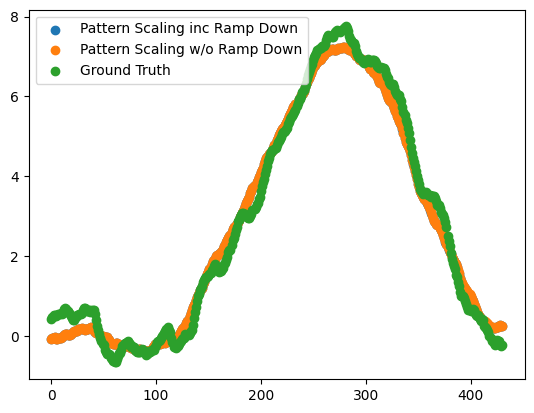

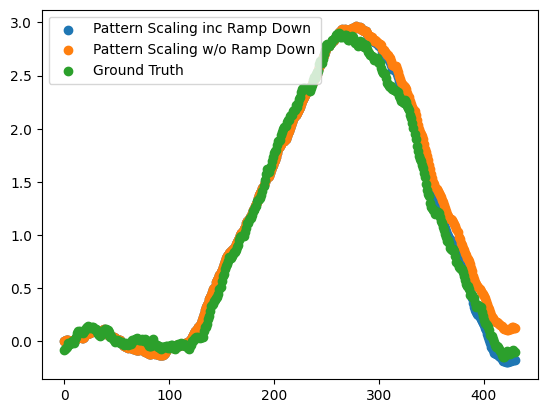

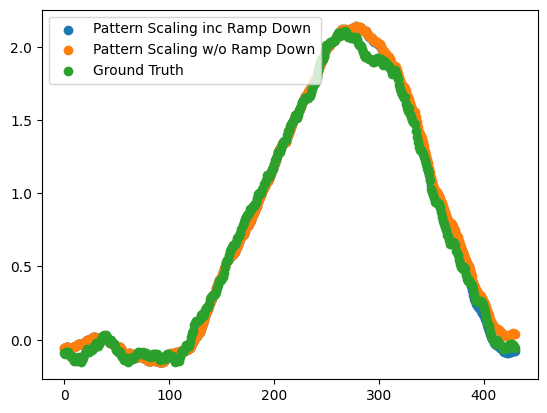

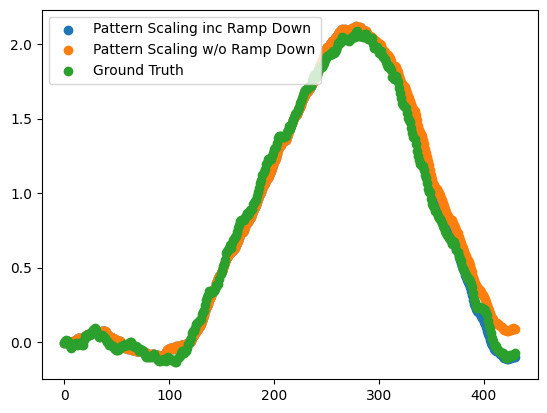

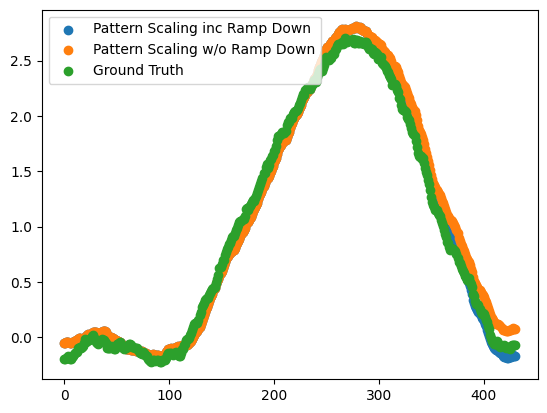

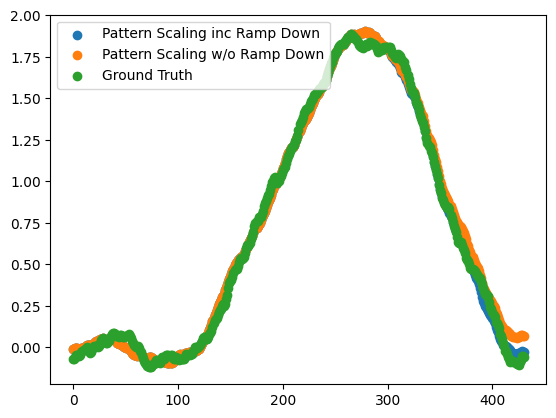

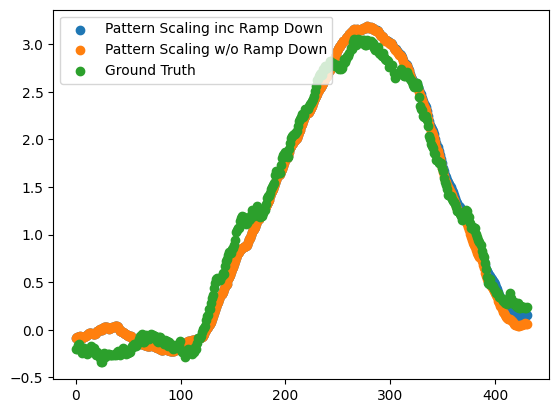

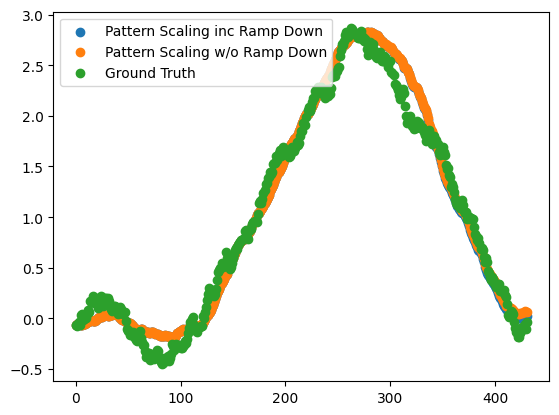

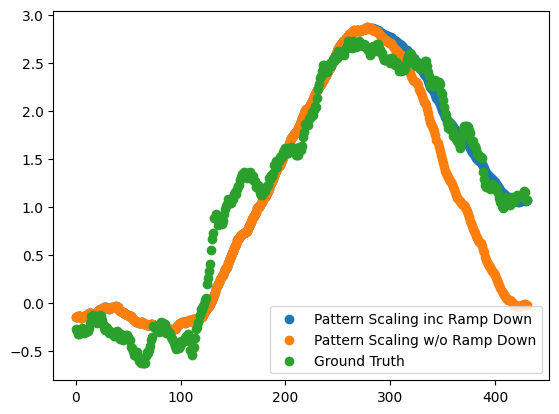

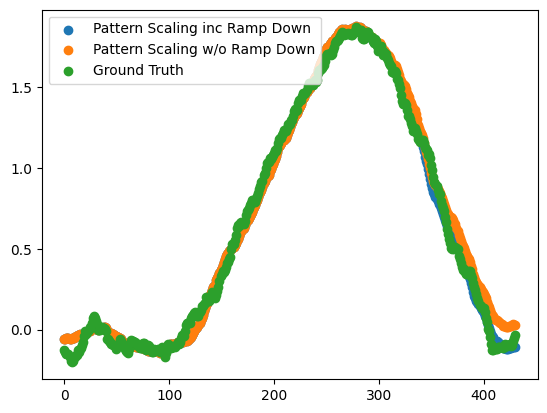

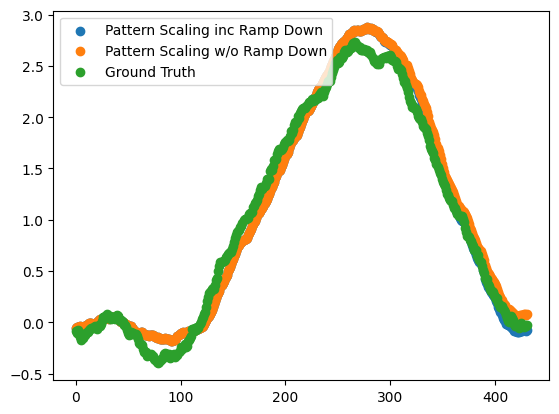

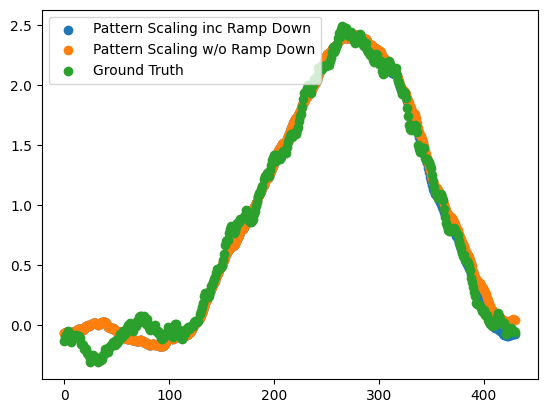

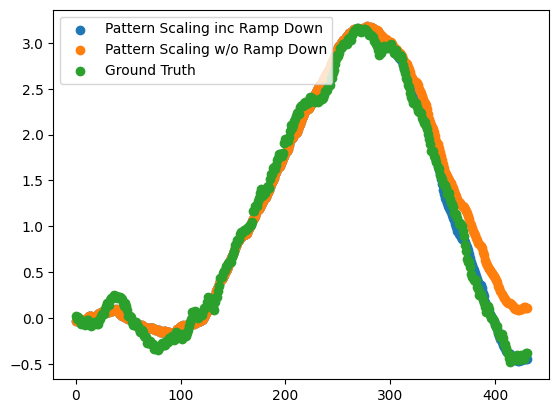

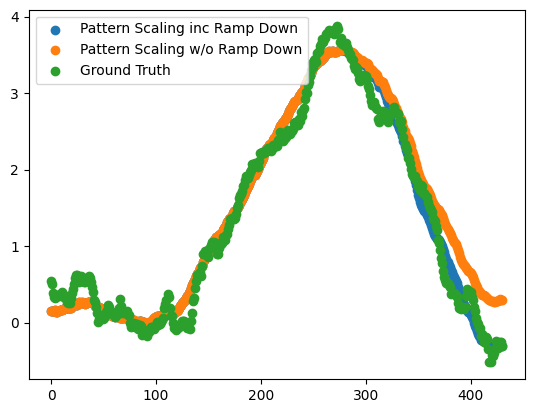

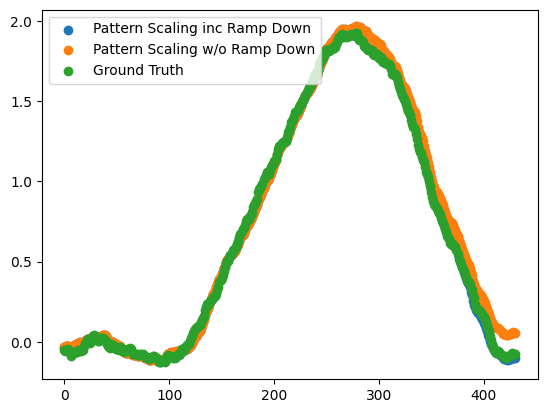

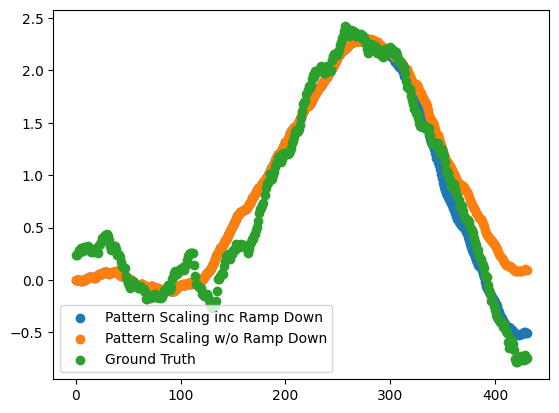

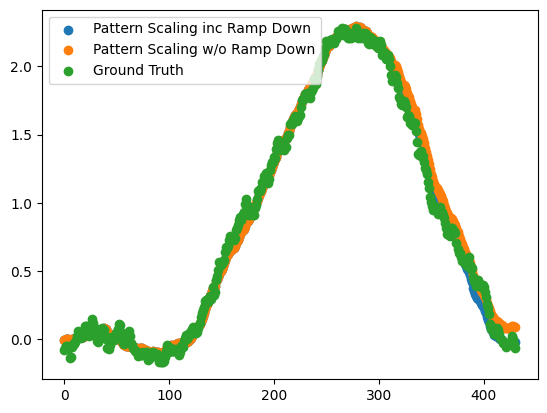

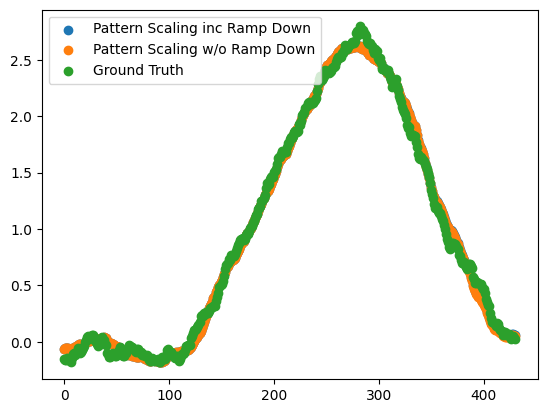

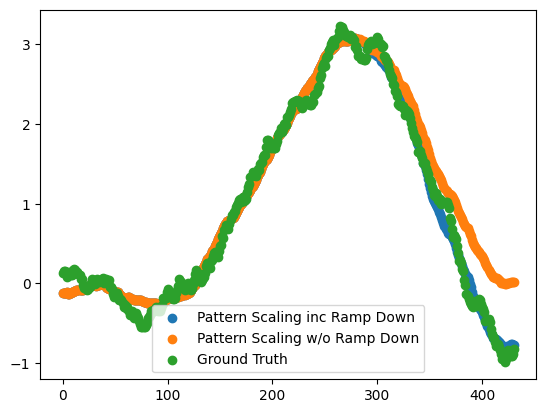

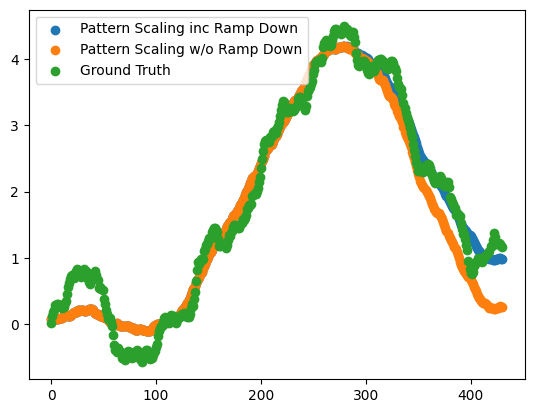

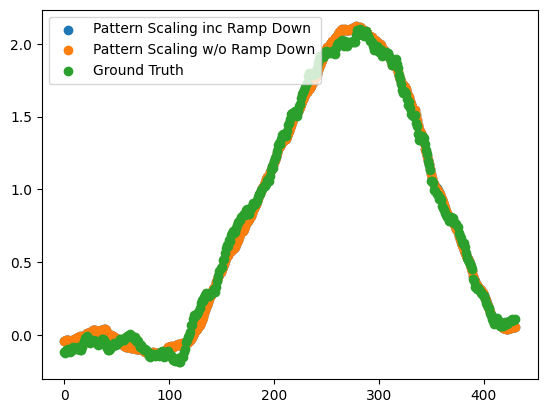

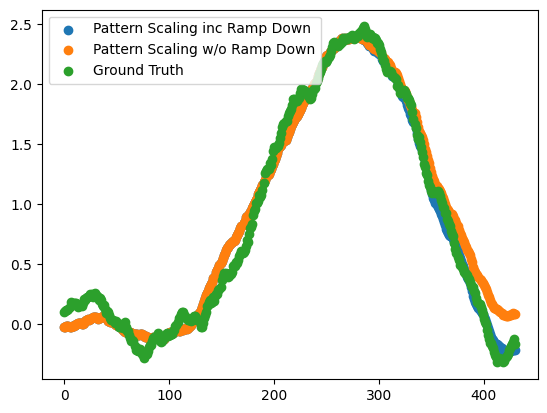

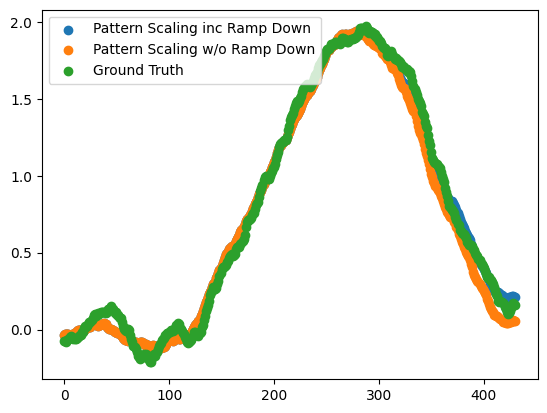

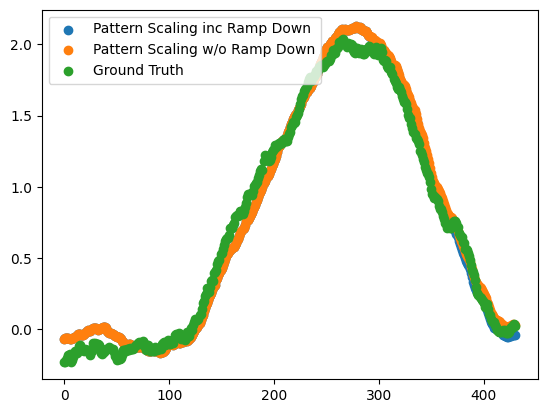

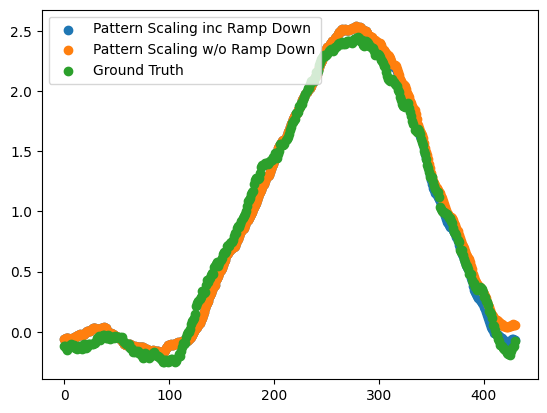

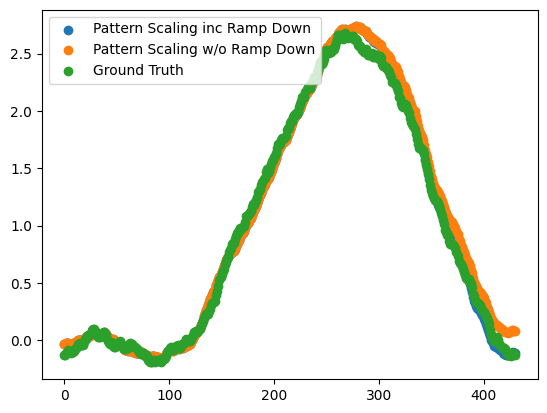

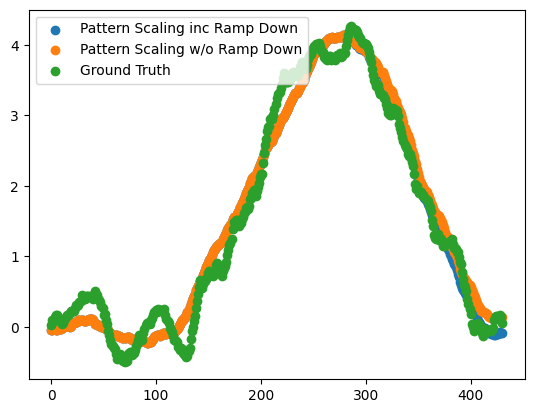

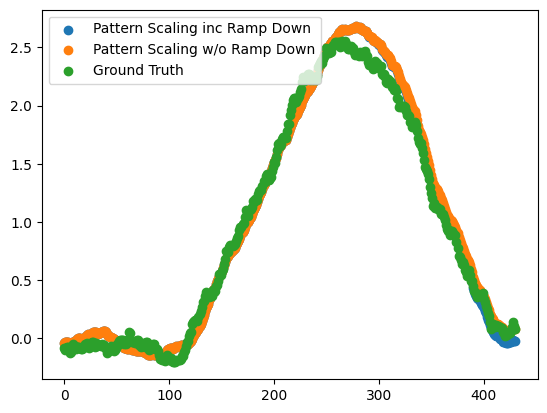

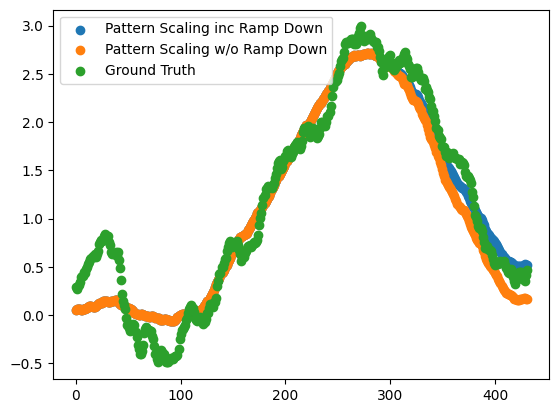

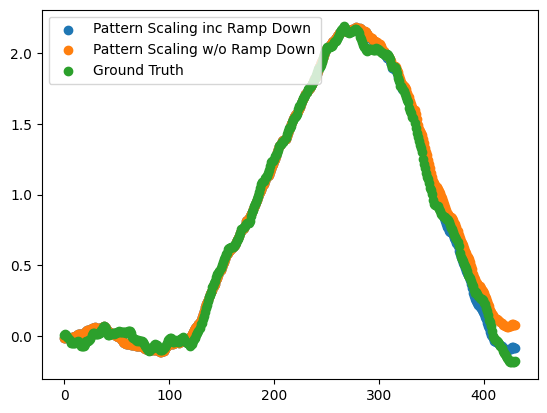

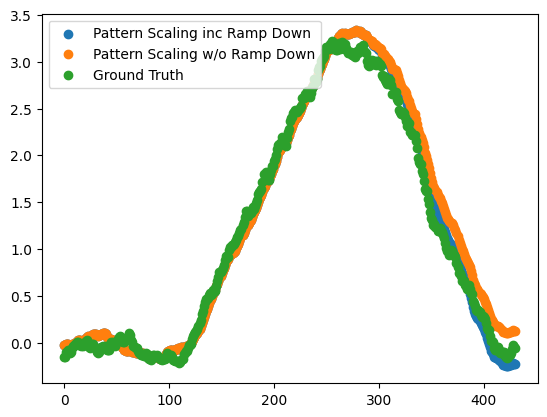

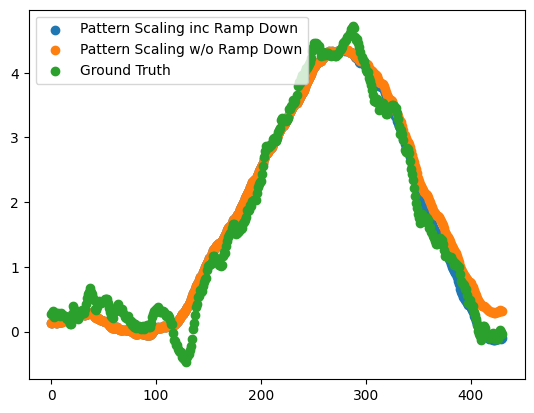

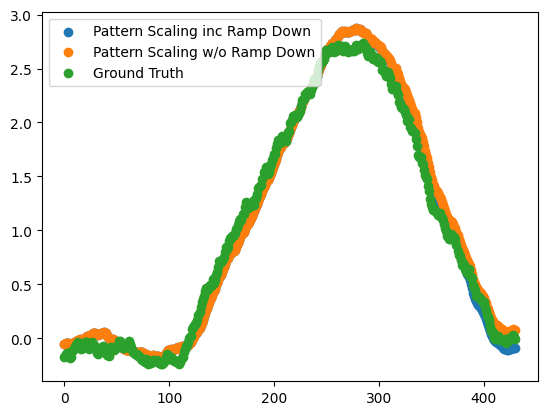

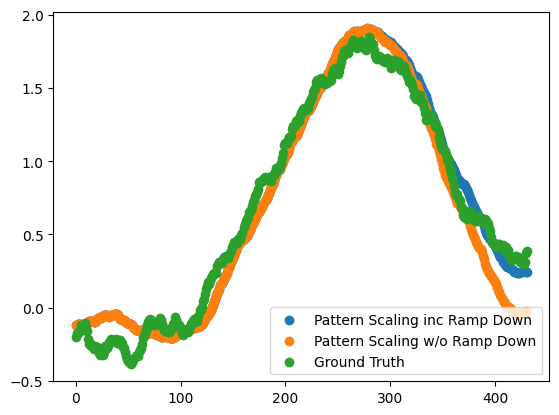

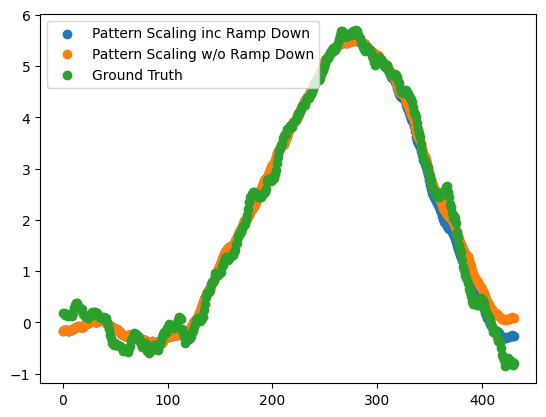

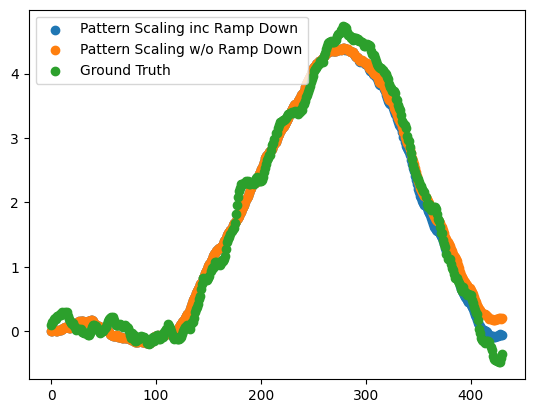

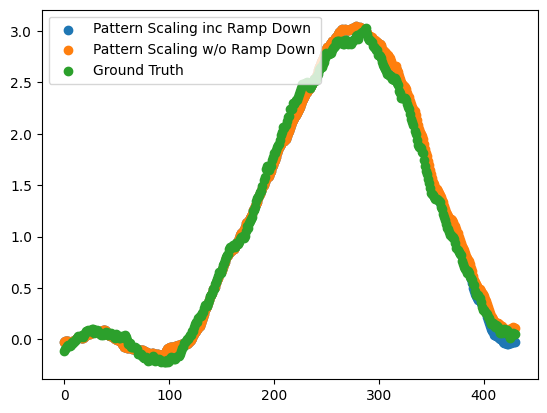

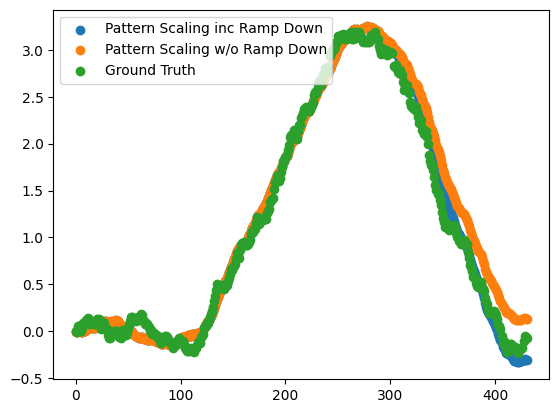

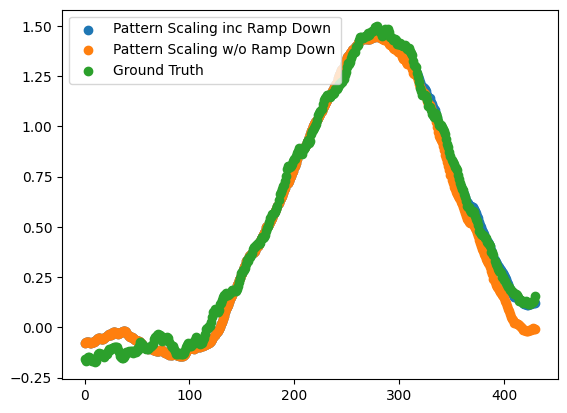

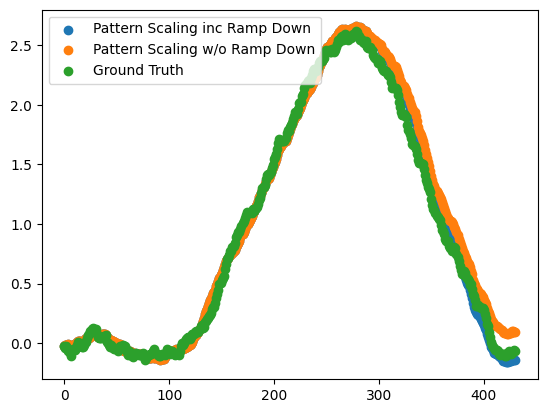

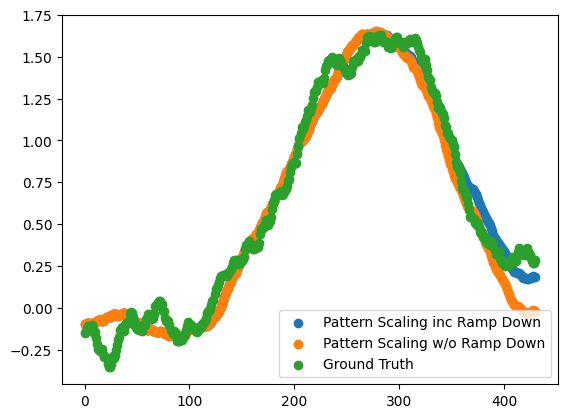

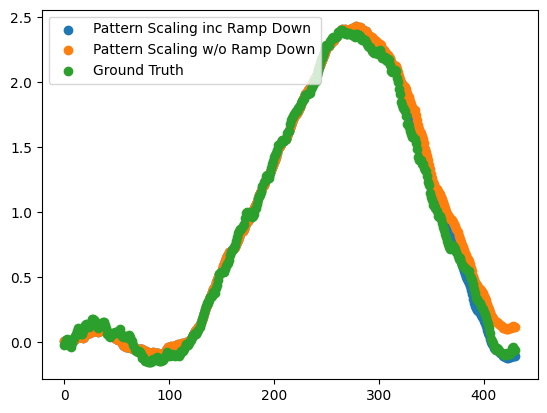

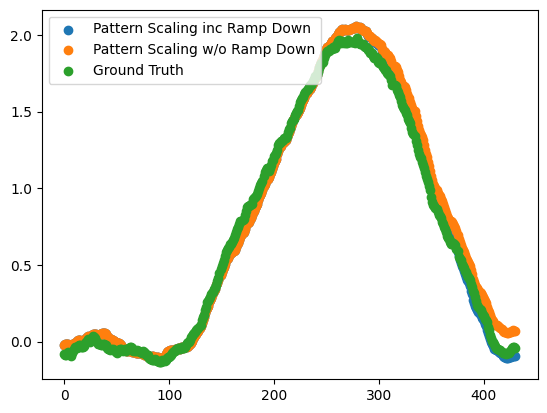

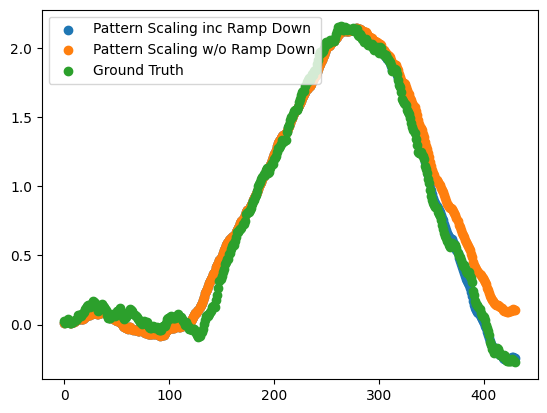

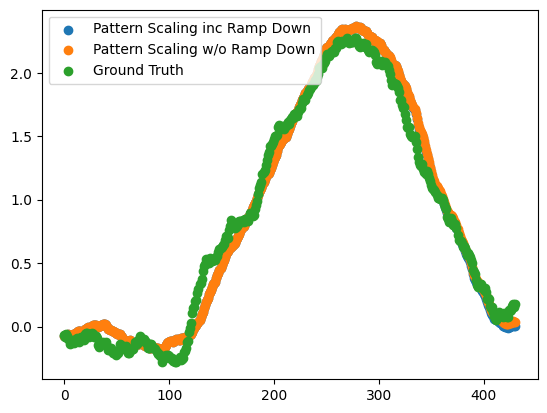

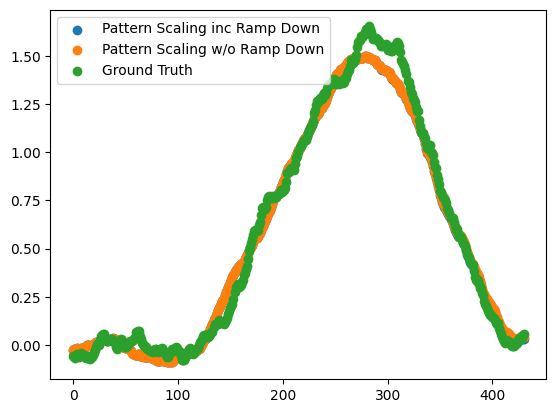

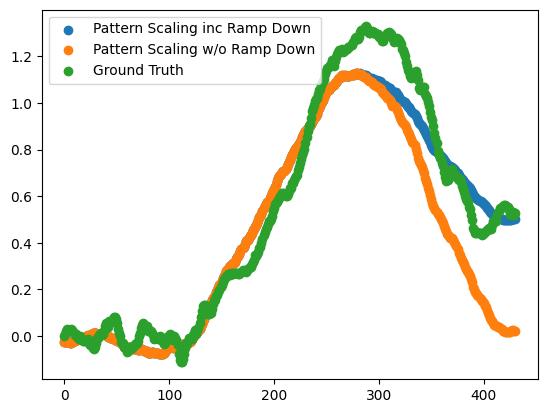

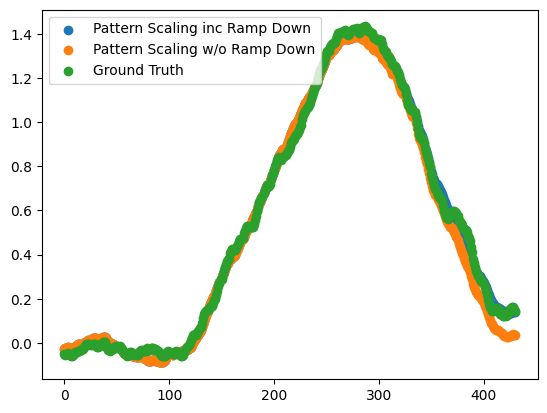

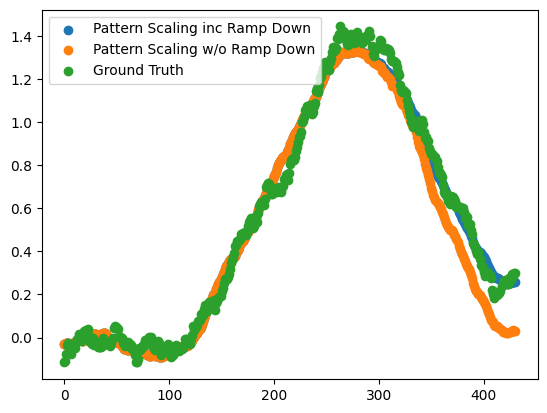

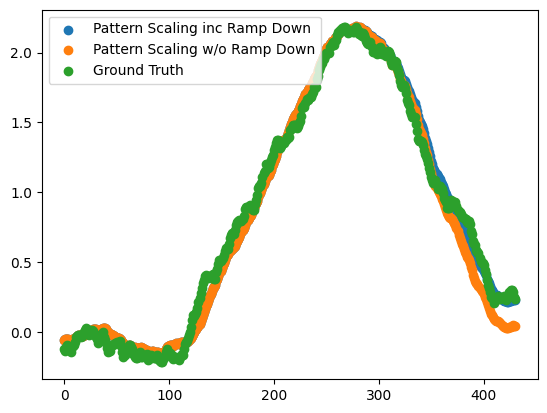

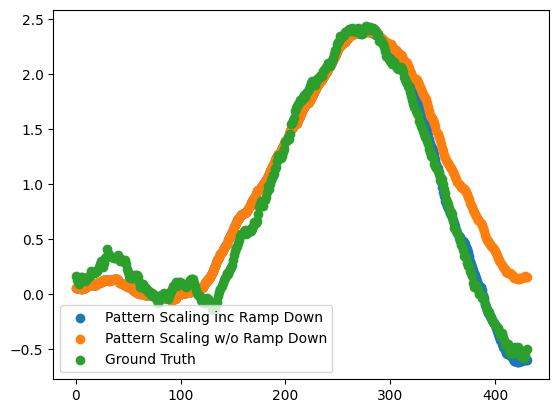

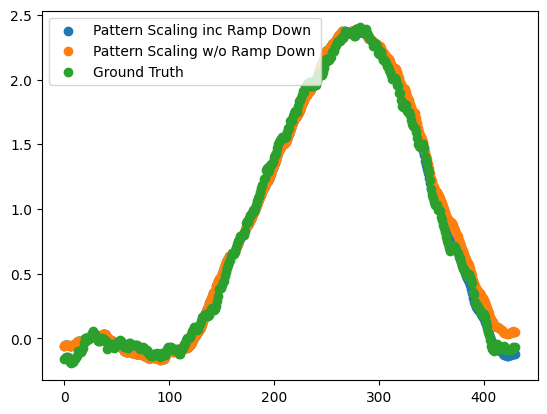

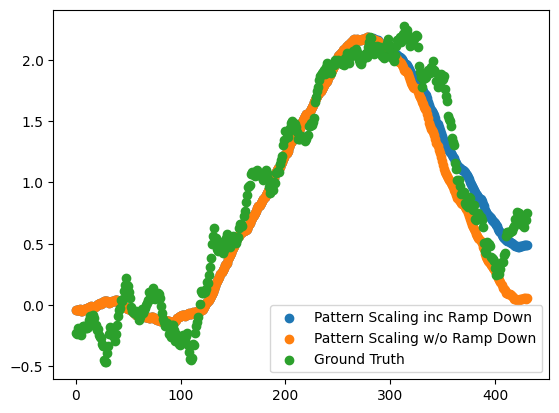

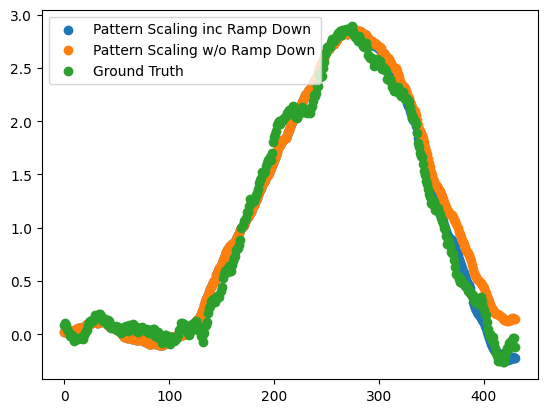

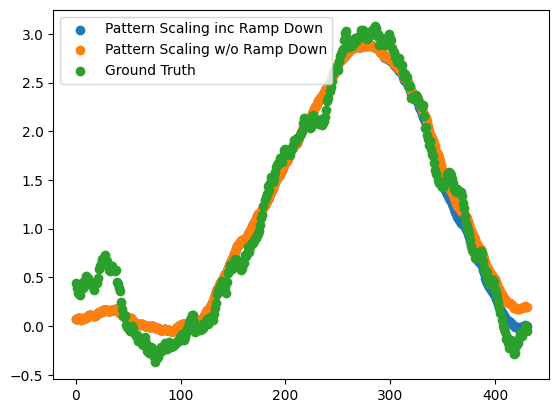

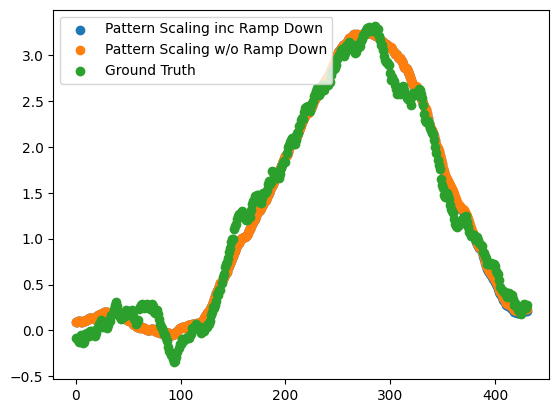

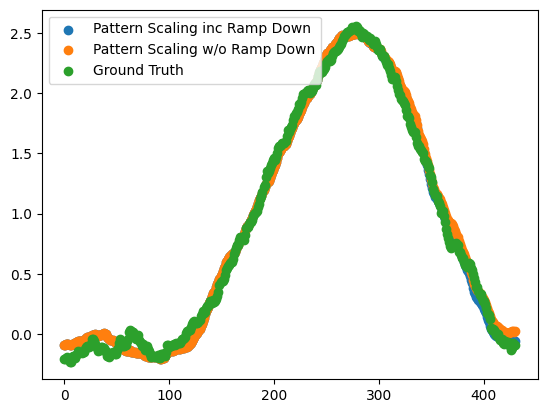

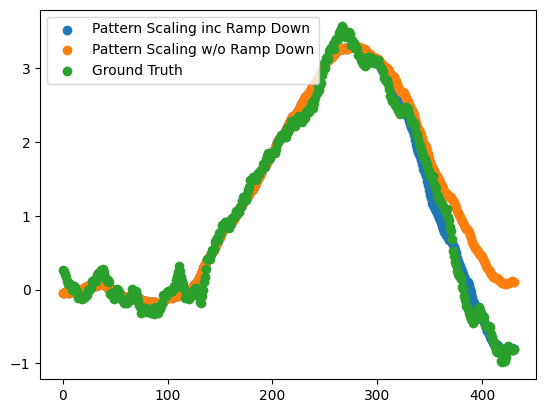

In [7]:
from sklearn.linear_model import LinearRegression

#def predict_regional_temperatures(global_test_series, slopes, intercepts):
#    """
#    Uses stored regression parameters to predict regional temps.
#    Returns:
 #       predictions: array of shape (len(global_test_series), n_regions)
#    """
#    global_test_series = np.asarray(global_test_series).reshape(-1, 1)
#    predictions = global_test_series * slopes + intercepts
#    return predictions

#def fit_regional_regressions(global_series, regional_series):
#    """
#    Fits one linear regression per region: region = a + b * global
#    Returns:
#        slopes:   (46,) array of regression coefficients
#        intercepts: (46,) array of intercepts
#    """
#    global_series = np.asarray(global_series).reshape(-1, 1)
#    regional_series = np.asarray(regional_series)
#    
#    n_regions = regional_series.shape[1]
#    slopes = np.zeros(n_regions)
#    intercepts = np.zeros(n_regions)
#
#    for i in range(n_regions):
#        model = LinearRegression()
#        model.fit(global_series, regional_series[:, i])
#        slopes[i] = model.coef_[0]
#        intercepts[i] = model.intercept_#
#
#    return slopes, intercepts

print(gmt_train)
print(gmt_train.shape)
print(train_data_regional_temperature)
print(train_data_regional_temperature.shape)
#slopes, intercepts = fit_regional_regressions(gmt_train, train_data_regional_temperature.transpose(1,0))
pattern_scaling_prediction = predict_regional_temperatures(gmt_autoregressive_test, regional_regression_slopes_intersepts["slopes_up"], regional_regression_slopes_intersepts["intercepts_up"], regional_regression_slopes_intersepts["slopes_down"], regional_regression_slopes_intersepts["intercepts_down"]).T
pattern_scaling_prediction_no_ramp_down = predict_regional_temperatures(gmt_autoregressive_test, regional_regression_slopes_intersepts["slopes_up"], regional_regression_slopes_intersepts["intercepts_up"], None, None).T
print(pattern_scaling_prediction.shape)
print(autoregressive_test_groudtruth.shape)
region = 9
for region in range(58):
    plt.scatter(np.arange((len(list(pattern_scaling_prediction[region,:])))) , pattern_scaling_prediction[region,:], label = 'Pattern Scaling inc Ramp Down')
    plt.scatter(np.arange((len(list(pattern_scaling_prediction[region,:])))) , pattern_scaling_prediction_no_ramp_down[region,:], label = 'Pattern Scaling w/o Ramp Down')
    plt.scatter(np.arange((len(list(pattern_scaling_prediction[region,:])))) , pattern_scaling_prediction[region,:] - autoregressive_test_groudtruth[region,:], label = 'Ground Truth')
    #autoregressive_test_groudtruth
    plt.legend()
    plt.show()

In [13]:

X_train = train_data_shuffeled[0].transpose(2,0,1)#
X_train = X_train.reshape(X_train.shape[0], -1)
Y_train = train_data_shuffeled[1].transpose(1,0)

X_test = test_data_input.transpose(2,0,1)#
X_test = X_test.reshape(X_test.shape[0], -1)
Y_test = test_data_output.transpose(1,0)

print(train_data_shuffeled[0].shape)

print(train_data_shuffeled[1].shape)

print(test_data_input.shape)

print(test_data_output.shape)


(59, 30, 34400)
(58, 34400)
(59, 30, 8000)
(58, 8000)


In [11]:
ML_MODEL = 'random_forest' 

Random Forest Model: 

(425, 295)
(425, 58)
[12, 12, 12, 13, 12, 12, 12, 12, 12, 12, 13, 12, 12, 12, 12, 11, 12, 12, 12, 12, 12, 14, 12, 11, 12, 13, 12, 14, 13, 12, 12, 13, 12, 12, 12, 12, 12, 13, 12, 12, 12, 12, 12, 12, 12, 13, 14, 12, 12, 12, 12, 12, 11, 11, 12, 12, 11, 12, 11, 12, 13, 12, 12, 12, 12, 12, 13, 12, 12, 12, 11, 12, 13, 12, 13, 12, 13, 12, 12, 12, 12, 13, 14, 12, 12, 12, 12, 13, 11, 12, 12, 13, 11, 12, 13, 12, 12, 12, 12, 12, 13, 13, 13, 13, 12, 12, 12, 13, 12, 12, 12, 12, 12, 13, 12, 12, 12, 13, 11, 12, 13, 13, 13, 13, 11, 12, 12, 14, 12, 13, 12, 12, 13, 12, 12, 11, 12, 12, 12, 11, 12, 13, 13, 12, 12, 11, 12, 11, 12, 11, 12, 13, 12, 12, 11, 12, 12, 13, 13, 12, 12, 13, 12, 12, 11, 11, 12, 12, 12, 13, 13, 11, 12, 12, 12, 12, 13, 12, 13, 12, 12, 13, 13, 12, 12, 13, 11, 12, 12, 13, 12, 12, 11, 12, 12, 13, 12, 12, 11, 11, 12, 14, 13, 11, 13, 12, 13, 12, 13, 13, 12, 13, 11, 12, 12, 12, 13, 12, 12, 12, 12, 13, 12, 12, 12, 13, 11, 13, 13, 12, 12, 12, 12, 12, 12, 13, 12, 14, 12, 12, 11, 13, 13, 12, 12

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


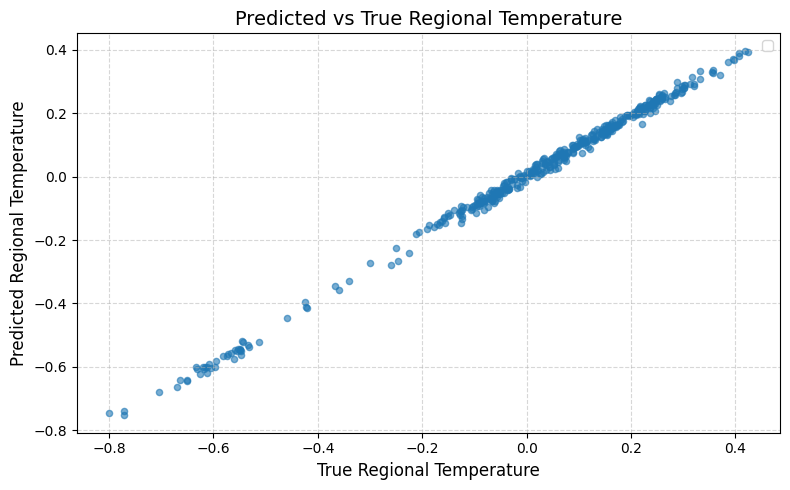

[-0.02876414 -0.02424221 -0.02396927 -0.02263156 -0.03341901]
431


(58, 431)
(58, 431)


'\n# =====================================================\n# 4) Function to extract per-tree prediction distribution\n# =====================================================\ndef rf_predict_distribution(model, x, quantiles=(0.1, 0.5, 0.9)):\n    """\n    Returns:\n      - samples: (n_trees, n_features)\n      - quantiles dict for each output dimension\n    """\n    #print("x shape ",x.shape, x.reshape(1,-1).shape)\n    all_preds = np.array([tree.predict(x.reshape(1, -1))[0]\n                          for tree in model.estimators_])\n    q_values = {dim: {q: np.quantile(all_preds[:, dim], q) for q in quantiles}\n                for dim in range(all_preds.shape[1])}\n    return all_preds, q_values\n# =====================================================\n# 5) Build prediction intervals for the test set\n# =====================================================\nlower_q, upper_q = 0.1, 0.9\nlower_bounds = []\nupper_bounds = []\nfor x in X_test:\n    samples, qv = rf_predict_distribution(rf

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
'''
# =====================================================
# 1) Create a 2D time series (two sine waves with noise)
# =====================================================
np.random.seed(42)
n_samples = 300
t = np.linspace(0, 20*np.pi, n_samples)
# Two correlated noisy sinusoid components
y1 = np.sin(t) + 0.2 * np.random.randn(n_samples)
y2 = np.cos(t) + 0.2 * np.random.randn(n_samples)
# Combine into a 2D time-series: shape (n_samples, 2)
y = np.column_stack([y1, y2])
print("y shape", y.shape)
# =====================================================
# 2) Convert to supervised learning problem with lags
# =====================================================
def make_lagged_features(data, n_lags=10):
    """
    Converts a multivariate time series into supervised format:
    X[i] contains lagged features of all variables;
    y_target[i] is the next multivariate time step.
    """
    X = []
    y_target = []
    for i in range(n_lags, len(data)):
        # Flatten the sliding window (lag dimension × variables)
        X.append(data[i-n_lags:i].flatten())
        # Target = next timestep (still 2D)
        y_target.append(data[i])
    return np.array(X), np.array(y_target)
n_lags = 15
X, y_target = make_lagged_features(y, n_lags=n_lags)
# Train-test split (no shuffling)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y_target[:train_size], y_target[train_size:]

print(X_train.shape)
print(y_train.shape)
'''
X_train = train_data_shuffeled[0].transpose(2,0,1)#
X_train = X_train.reshape(X_train.shape[0], -1)
Y_train = train_data_shuffeled[1].transpose(1,0)

X_test = test_data_input.transpose(2,0,1)#
X_test = X_test.reshape(X_test.shape[0], -1)
Y_test = test_data_output.transpose(1,0)

print(X_train.shape)
print(Y_train.shape)
# =====================================================
# 3) Train probabilistic RandomForest model
# =====================================================

def train_model(X_train, Y_train, model_type = 'random_forest'):
    
    if model_type =='random_forest':
        model = RandomForestRegressor(
            n_estimators=300,
            n_jobs= 150,
            random_state=0,
            #ccp_alpha=0.0002,
            #min_samples_leaf=1,
        )
        model.fit(X_train, Y_train)

        depths = [tree.tree_.max_depth for tree in model.estimators_]
        print(depths)
    elif model_type == 'xgboost': 

        # Define XGBRegressor model parameters
        params = {
            'objective': 'reg:squarederror',
            'max_depth': 10,
            'learning_rate': 0.1,
            'n_estimators': 500,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42,
            'n_jobs': 150
        }

        # Instantiate XGBRegressor with the parameters
        model = xgb.XGBRegressor(**params)

        # Train the model
        model.fit(X_train, Y_train)

    return model

model = train_model(X_train, Y_train, model_type = ML_MODEL)


# Point forecast (forest mean prediction)
point_preds = model.predict(X_test)
mae = mean_absolute_error(Y_test, point_preds)
print(f"Test MAE (point forecast): {mae:.3f}")



def plot_gmt_vs_regional(gmt, regional_pred, regional_true):
    plt.figure(figsize=(8, 5))

    # Scatter plots with smaller points and transparency
    plt.scatter(regional_true, regional_pred, s=20, alpha=0.6)
    #plt.scatter(gmt, , s=20, alpha=0.6, label="Predicted Regional Temperature")

    # Labels and title
    plt.xlabel("True Regional Temperature", fontsize=12)
    plt.ylabel("Predicted Regional Temperature", fontsize=12)
    plt.title("Predicted vs True Regional Temperature", fontsize=14)

    # Grid and layout
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
region_number = 8
GMT = X_test[:,N]
reg_temp_pred = point_preds[:,region_number]
reg_temp_true = Y_test[:,region_number]
plot_gmt_vs_regional(GMT, reg_temp_pred, reg_temp_true)


def iterative_forecast(matrix, gmt_array, model, quantiles = None):
    """
    Iteratively forecasts regional temperatures using a RandomForestRegressor.
    
    Parameters:
    ----------
    matrix : np.ndarray
        Shape (1 + number_regions, n), 
        First row: GMT values from t-n to t
        Other rows: regional temps from t-n-1 to t-1
        
    gmt_array : np.ndarray
        1D array of GMT values, indexed from t+1 onward
        
    model : trained RandomForestRegressor
        Takes matrix as input and predicts regional temp at time t
        
    Returns:
    -------
    np.ndarray
        Full time series of predicted regional temperatures
        Shape: (number_regions, total_timesteps_predicted)
    """
    
    num_regions = matrix.shape[0] - 1
    n = matrix.shape[1]
    
    # Store predictions over time
    predictions_over_time = []

    # Index to iterate through GMT array
    gmt_index = n  # since matrix already holds GMT up to t
    
    while gmt_index < len(gmt_array):

        # Step 1: Prepare input (flatten matrix or reshape as needed by model)
        model_input = matrix.flatten().reshape(1, -1)
        
        # Step 2: Predict regional temperature at time t
        pred = model.predict(model_input).flatten()  # shape (num_regions,)
        if quantiles is not None: 
            all_preds = np.array([tree.predict(x.reshape(1, -1))[0]
                          for tree in model.estimators_])
            q_values = {dim: {q: np.quantile(all_preds[:, dim], q) for q in quantiles}
                for dim in range(all_preds.shape[1])}

        predictions_over_time.append(pred)
        
        # Step 3: Update matrix
        
        # Shift all columns left (remove first column)
        matrix = np.roll(matrix, shift=-1, axis=1)
        
        # Insert new GMT value in first row, last col
        matrix[0, -1] = gmt_array[gmt_index]
        
        # Insert predicted regional temps in remaining rows
        matrix[1:, -1] = pred
        
        # Move to next GMT value
        gmt_index += 1
    
    return np.array(predictions_over_time).T  # shape: (num_regions, timesteps)

print(test_data_for_autoregression_input[0,:,0])
print(len(gmt_autoregressive_test))


output_autoregression = iterative_forecast(test_data_for_autoregression_input[:,:,0], gmt_autoregressive_test, model)
full_reg_pred_with_spin_off = np.concatenate((test_data_for_autoregression_input[1:,:,0] ,output_autoregression), axis = 1)

print(full_reg_pred_with_spin_off.shape)
print(autoregressive_test_groudtruth.shape)


num_series = full_reg_pred_with_spin_off.shape[0]
timesteps = full_reg_pred_with_spin_off.shape[1]
region_names = ['ARO', 'ARP', 'ARS', 'BOB', 'CAF', 'CAR', 'CAU',
       'CNA', 'EAN', 'EAO', 'EAS', 'EAU', 'ECA', 'EEU', 'EIO', 'ENA', 'EPO',
       'ESAF', 'ESB', 'GIC', 'MDG', 'MED', 'NAO', 'NAU', 'NCA', 'NEAF', 'NEN',
       'NES', 'NEU', 'NPO', 'NSA', 'NWN', 'NWS', 'NZ', 'RAR', 'RFE', 'SAH',
       'SAM', 'SAO', 'SAS', 'SAU', 'SCA', 'SEA', 'SEAF', 'SES', 'SIO', 'SOO',
       'SPO', 'SSA', 'SWS', 'TIB', 'WAF', 'WAN', 'WCA', 'WCE', 'WNA', 'WSAF',
       'WSB','GLOBAL']
#for i in range(num_series):
#    plt.figure(figsize=(10, 4))
#    plt.plot(range(timesteps), autoregressive_test_groudtruth[i], label="Ground Truth")
#    if PATTERN_SCALING_RESIDUALS:
#        plt.plot(range(timesteps), pattern_scaling_prediction[:,i] + full_reg_pred_with_spin_off[i], label="Predicted")
#        plt.plot(range(timesteps), pattern_scaling_prediction[i,:], label="Pattern Scaling Prediction")
#    else:
#        plt.plot(range(timesteps), full_reg_pred_with_spin_off[i], label="Predicted")
#        plt.plot(range(timesteps), pattern_scaling_prediction[:,i], label="Pattern Scaling Prediction")
#    plt.xlabel("Time Step")
#    plt.ylabel("Value")
#    plt.title(f"{region_names[i]} region: Predicted vs Ground Truth")
#    plt.legend()
#    plt.grid(True)
#    plt.show()

'''
# =====================================================
# 4) Function to extract per-tree prediction distribution
# =====================================================
def rf_predict_distribution(model, x, quantiles=(0.1, 0.5, 0.9)):
    """
    Returns:
      - samples: (n_trees, n_features)
      - quantiles dict for each output dimension
    """
    #print("x shape ",x.shape, x.reshape(1,-1).shape)
    all_preds = np.array([tree.predict(x.reshape(1, -1))[0]
                          for tree in model.estimators_])
    q_values = {dim: {q: np.quantile(all_preds[:, dim], q) for q in quantiles}
                for dim in range(all_preds.shape[1])}
    return all_preds, q_values
# =====================================================
# 5) Build prediction intervals for the test set
# =====================================================
lower_q, upper_q = 0.1, 0.9
lower_bounds = []
upper_bounds = []
for x in X_test:
    samples, qv = rf_predict_distribution(rf, x, quantiles=(lower_q, upper_q))
    lower_bounds.append([qv[0][lower_q], qv[1][lower_q]])
    upper_bounds.append([qv[0][upper_q], qv[1][upper_q]])d
lower_bounds = np.array(lower_bounds)
upper_bounds = np.array(upper_bounds)


# =====================================================
# 6) Plot forecasts for both dimensions
# =====================================================
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
labels = ["Component 1 (sin)", "Component 2 (cos)"]
for i, ax in enumerate(axes):
    ax.plot(Y_test[:, i], label="True", linewidth=1.5)
    ax.plot(point_preds[:, i], label="Mean prediction", linewidth=1)
    ax.fill_between(
        np.arange(len(Y_test[:, i])),
        lower_bounds[:, i],
        upper_bounds[:, i],
        alpha=0.2,
        label=f"{int(lower_q*100)}–{int(upper_q*100)}% interval"
    )
    ax.set_ylabel(labels[i])
    ax.legend()
plt.xlabel("Time index (test set)")
plt.suptitle("One-step-ahead probabilistic forecast: 2 features")
plt.tight_layout()
plt.show()
'''

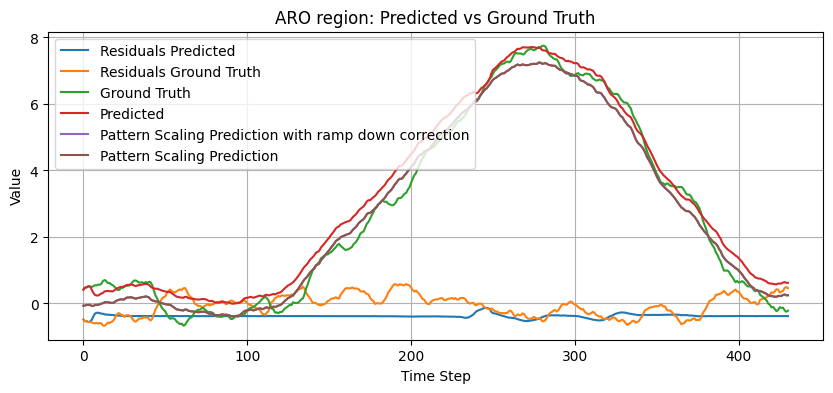

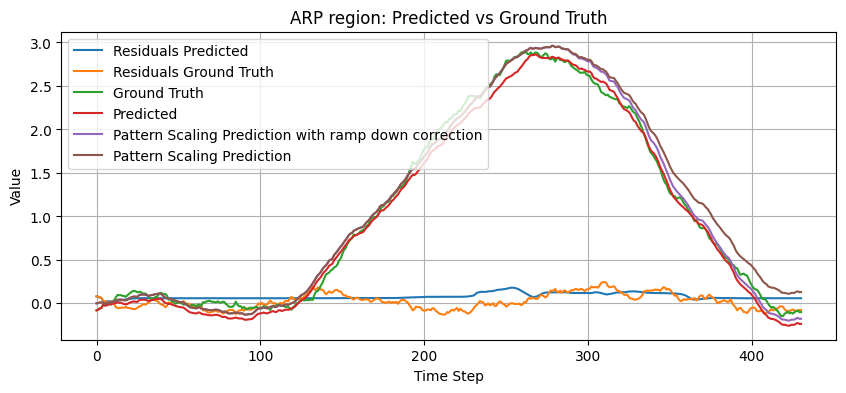

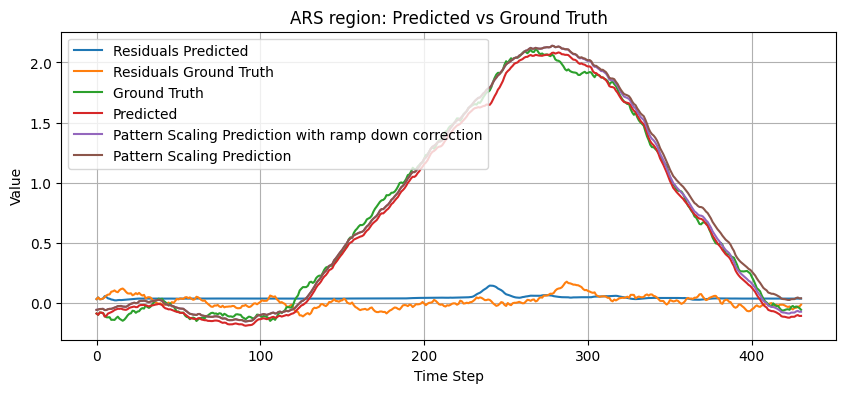

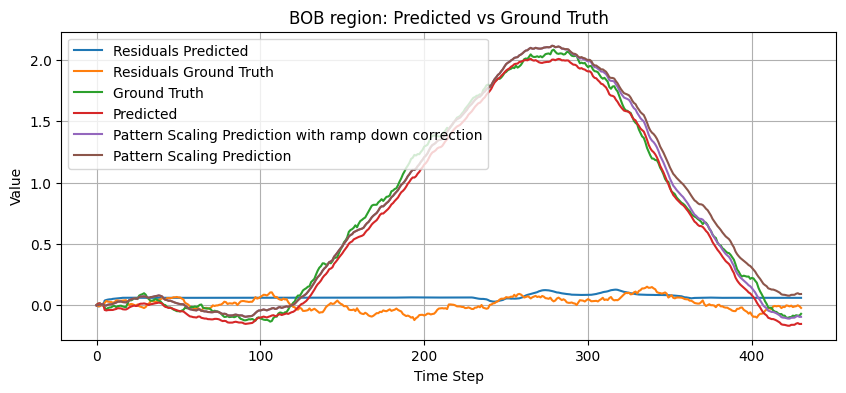

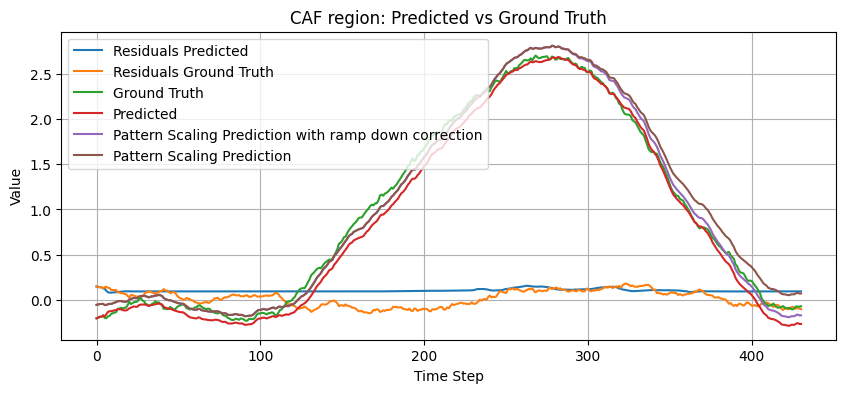

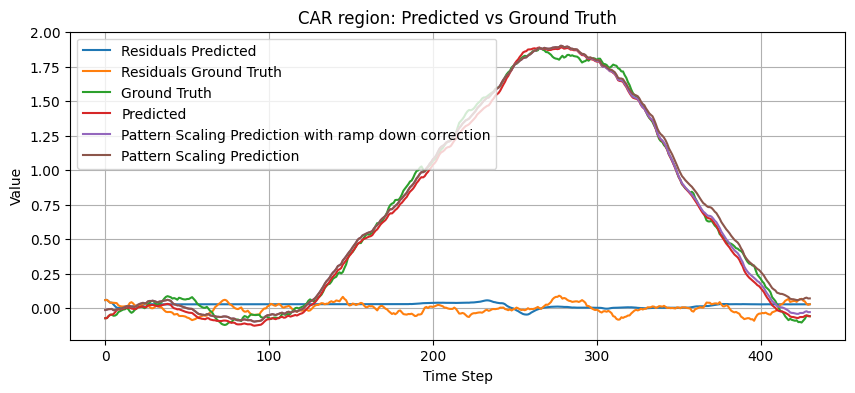

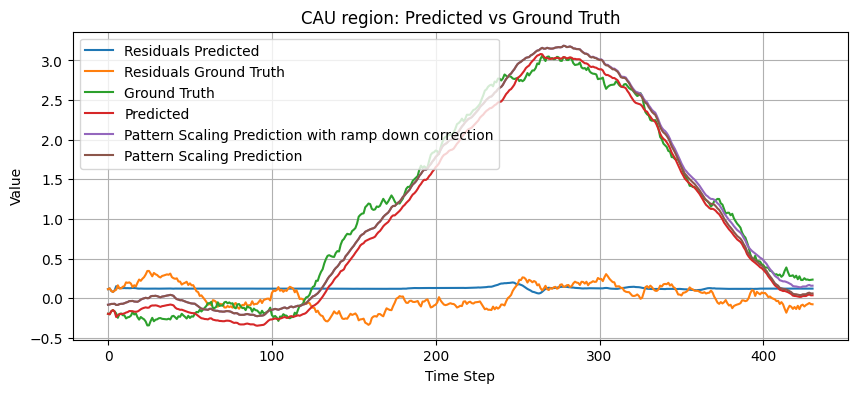

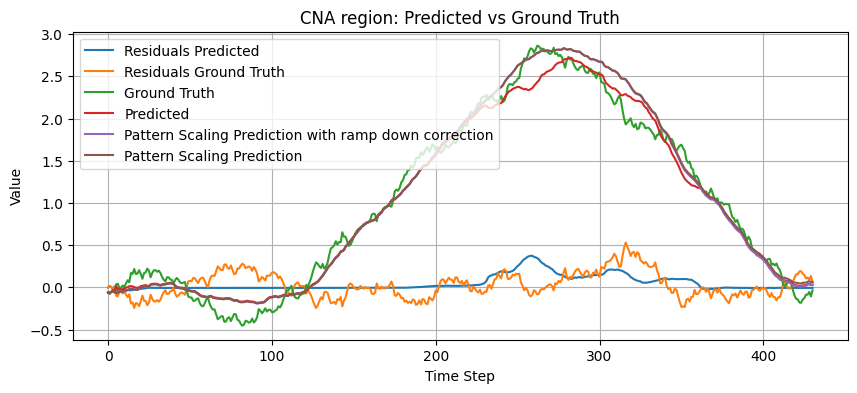

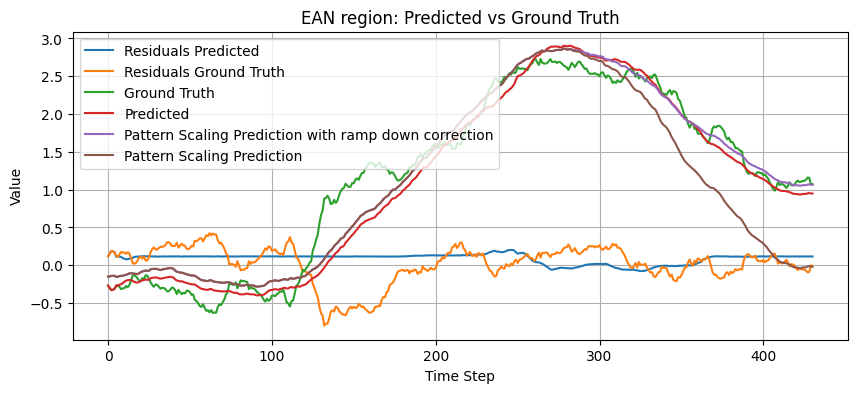

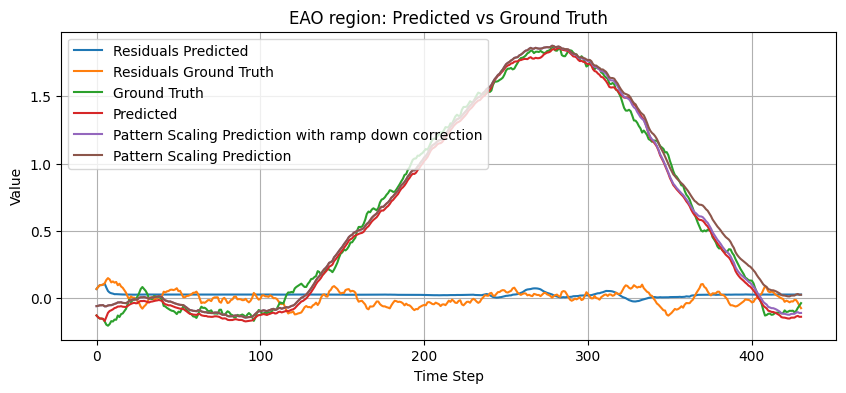

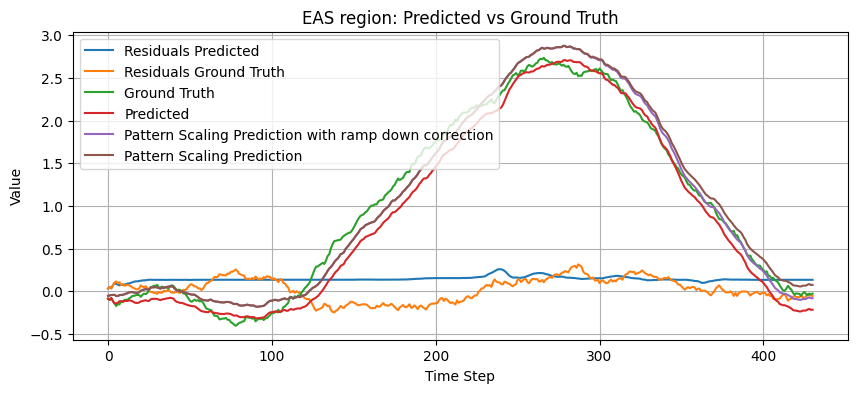

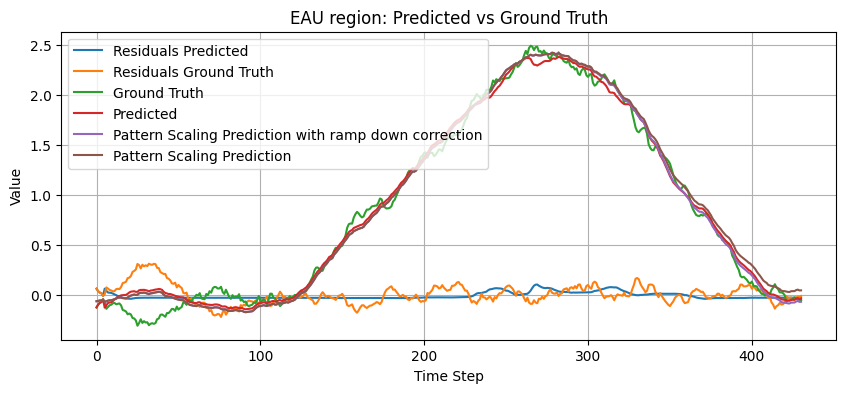

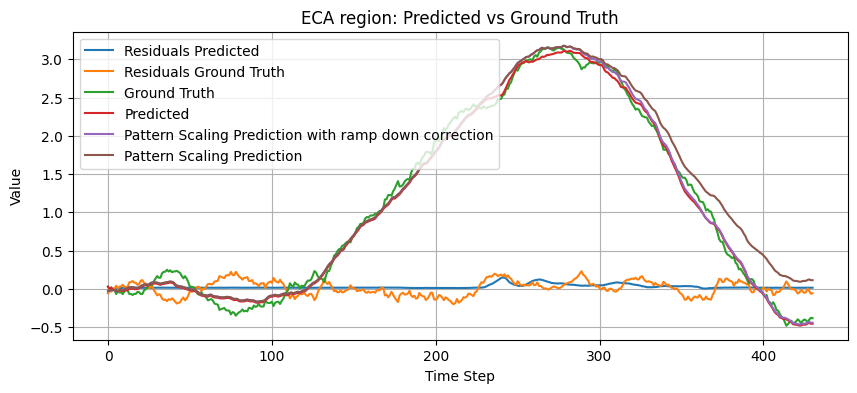

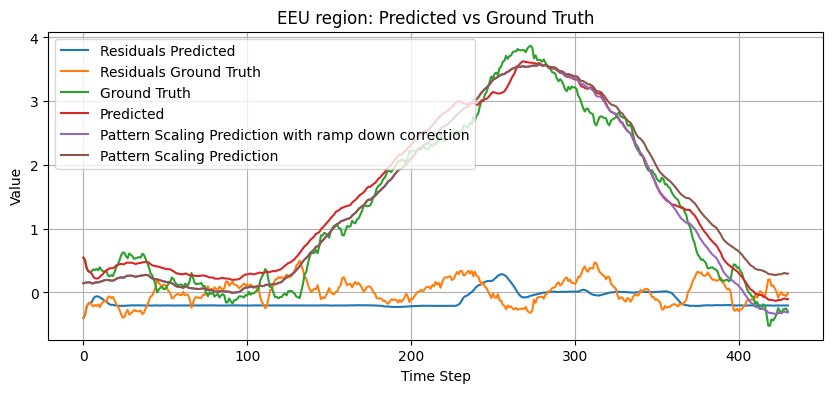

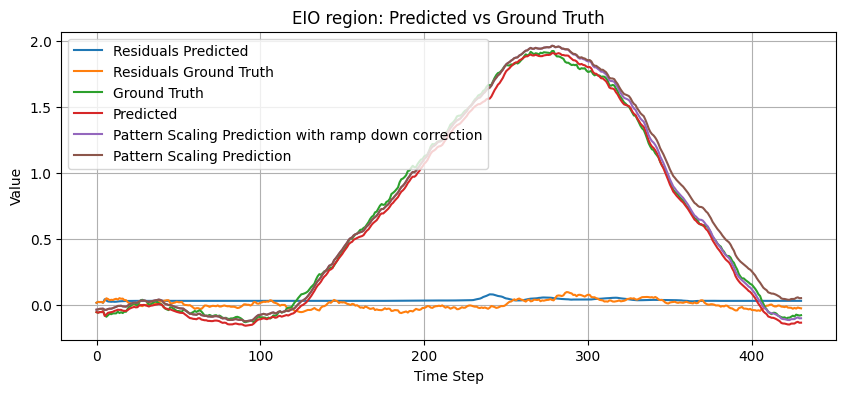

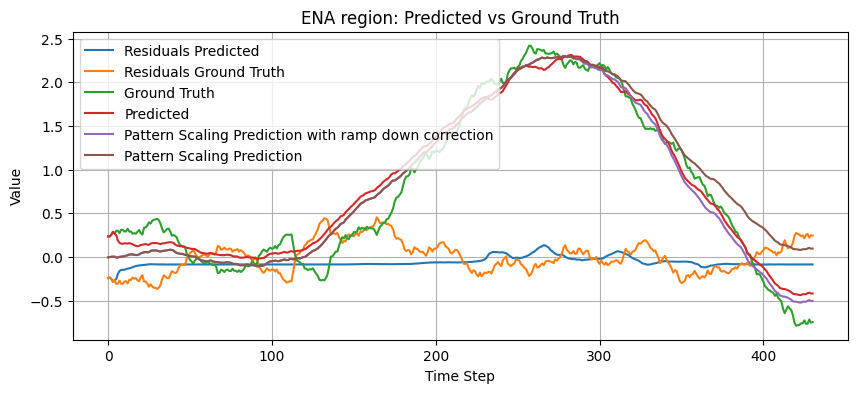

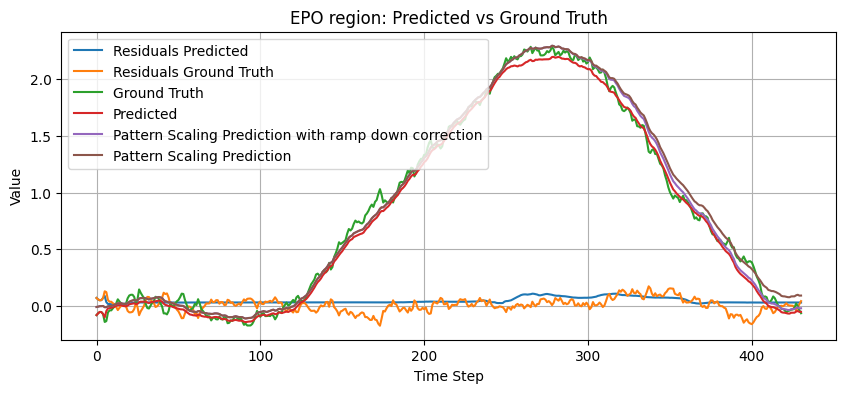

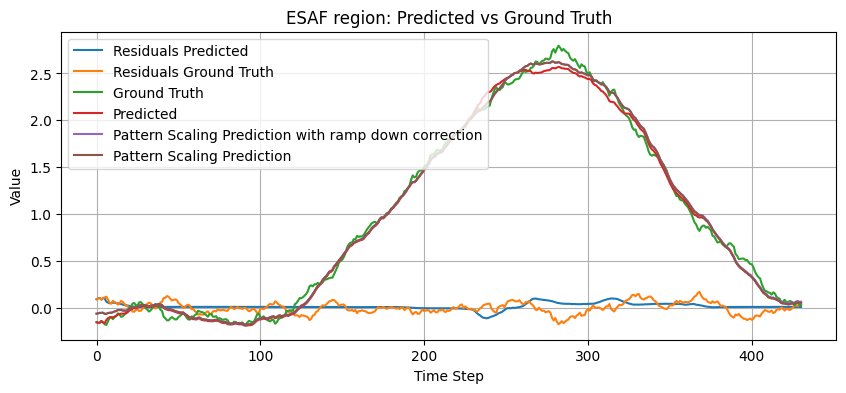

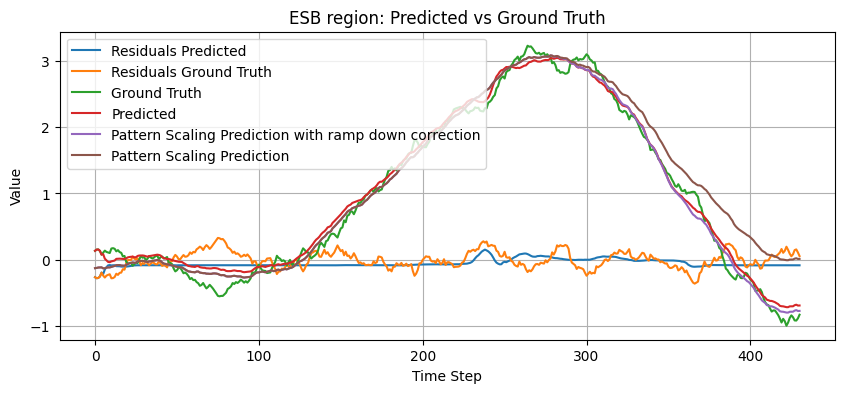

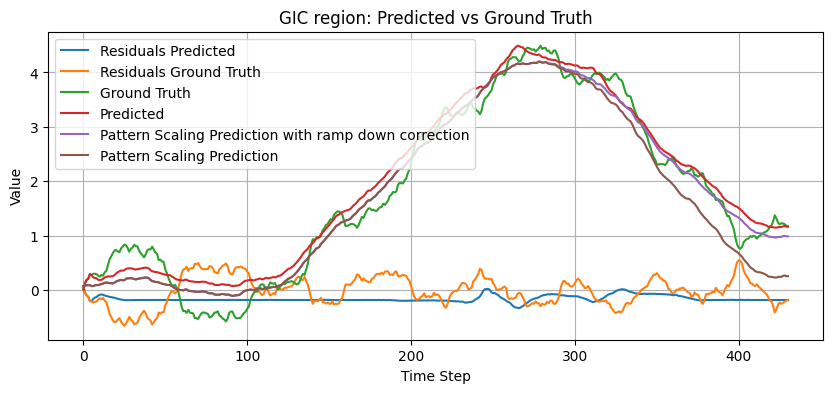

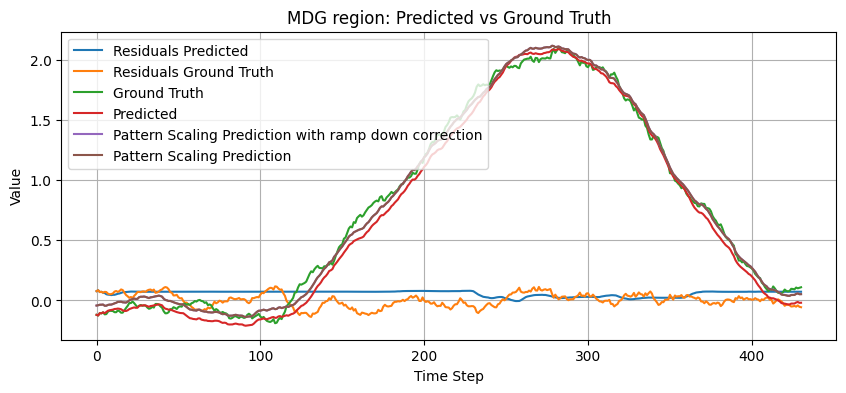

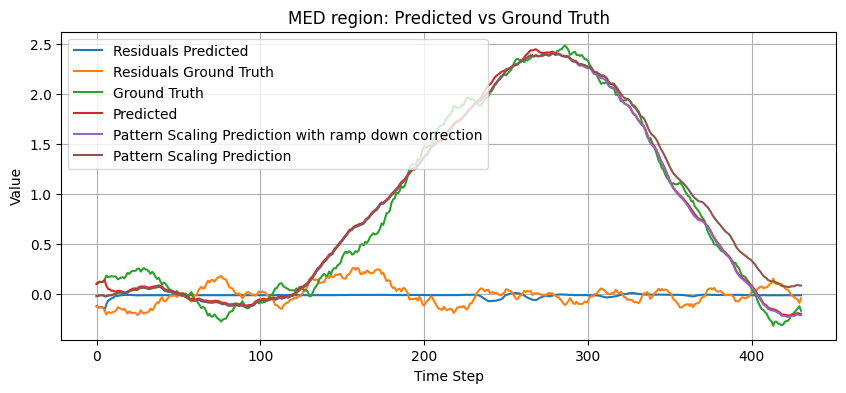

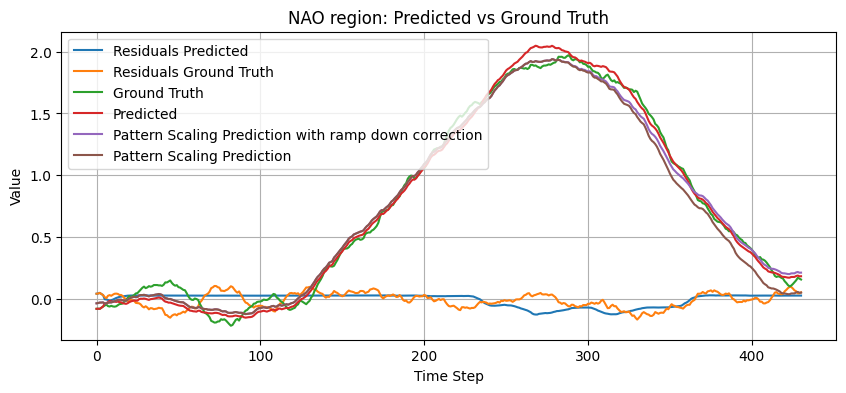

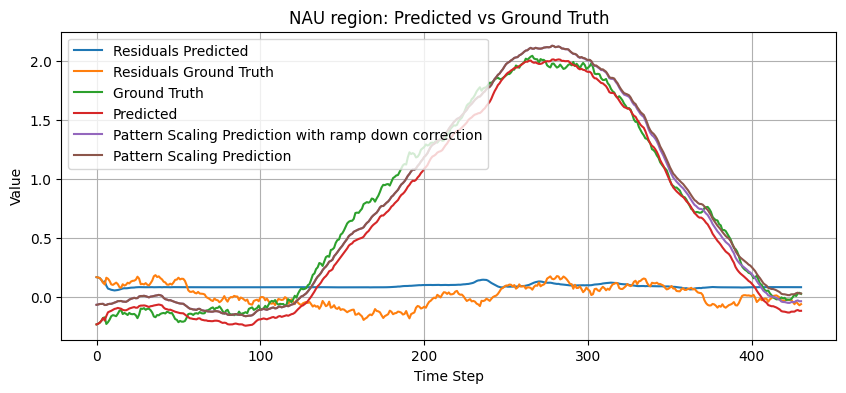

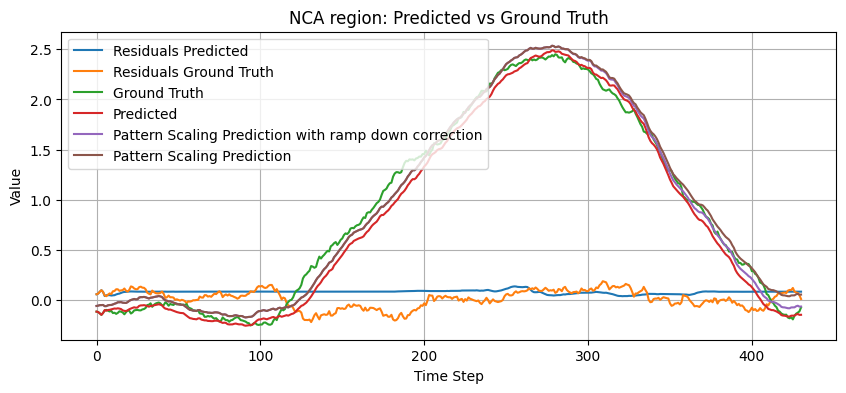

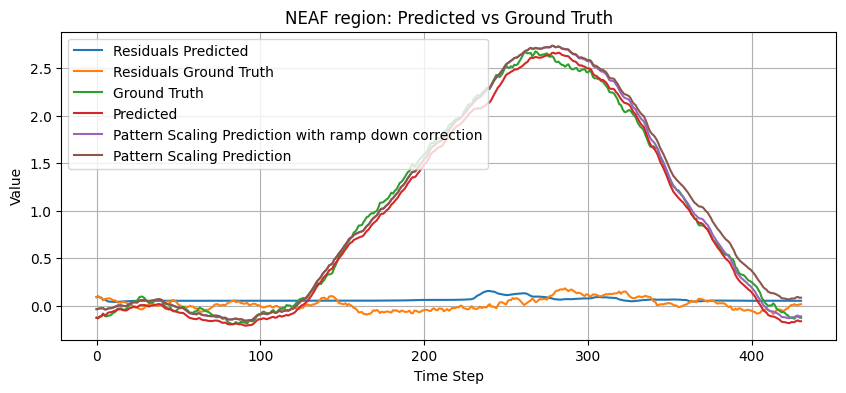

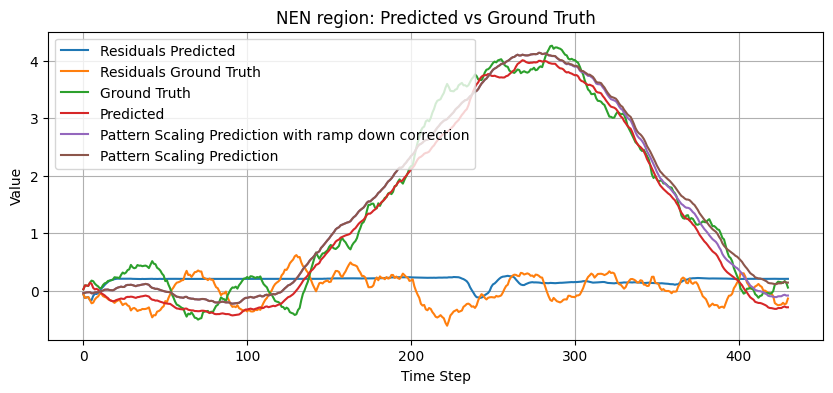

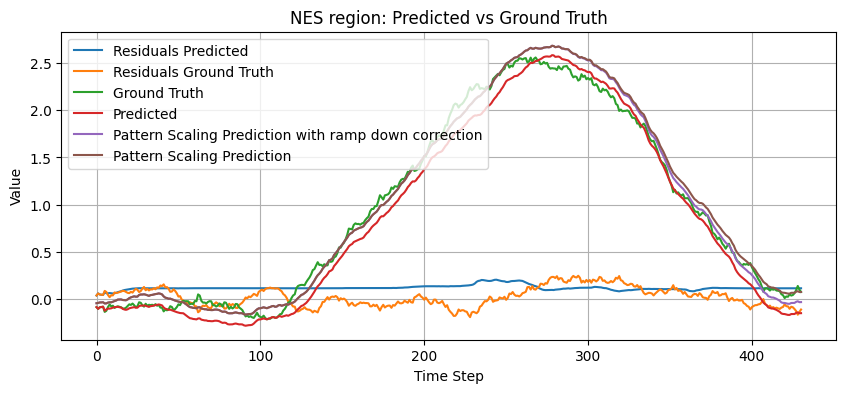

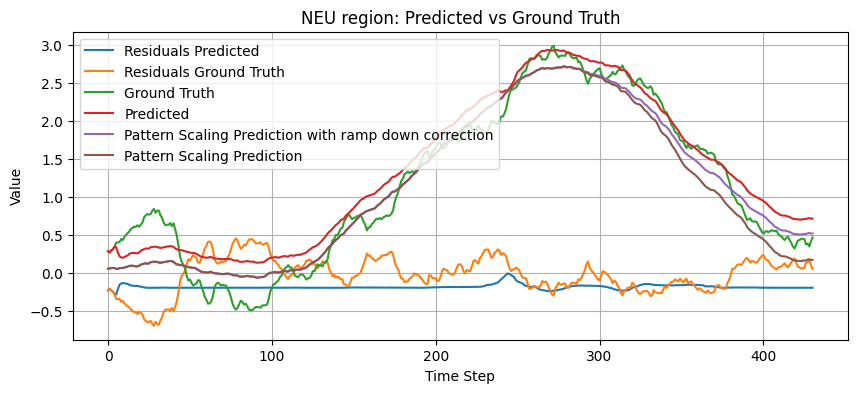

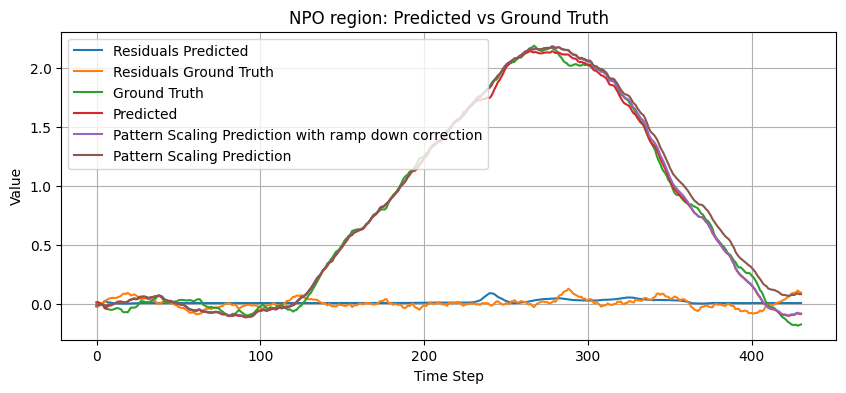

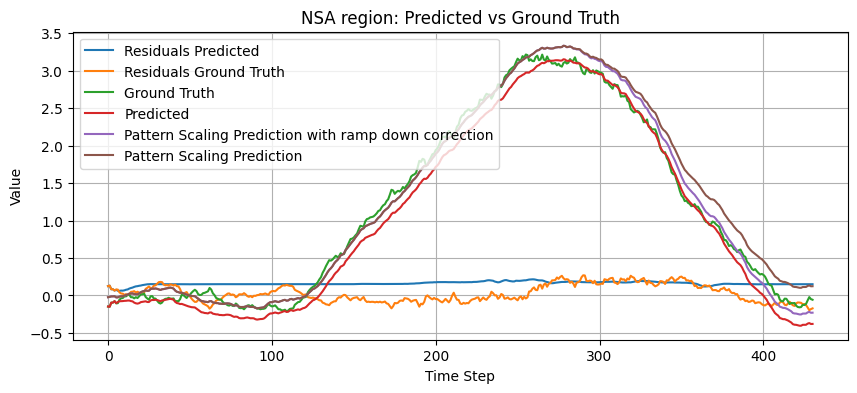

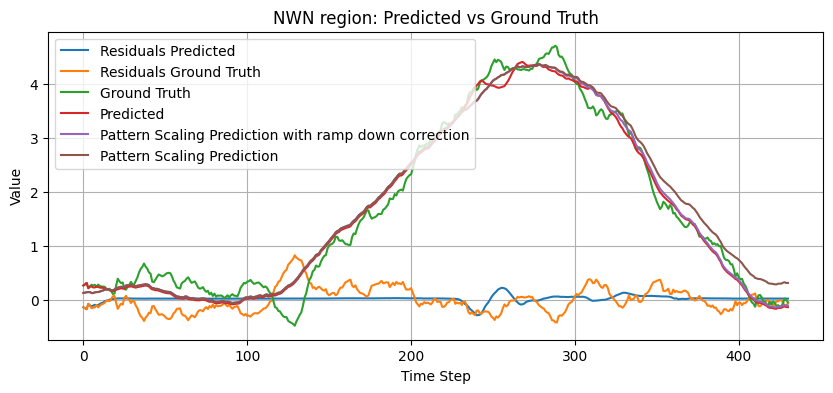

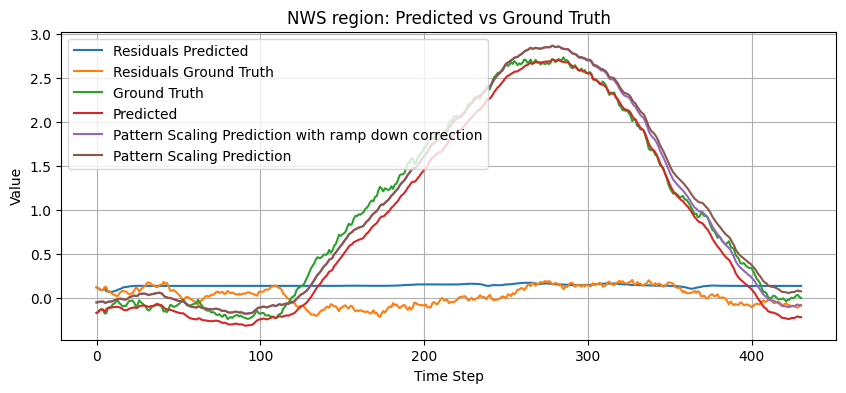

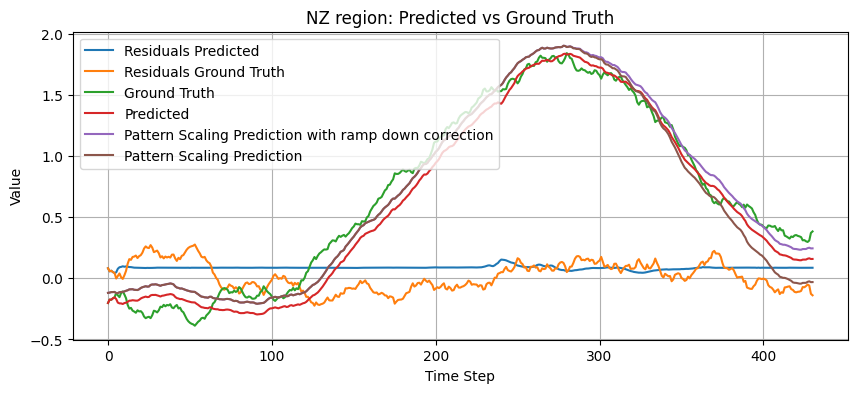

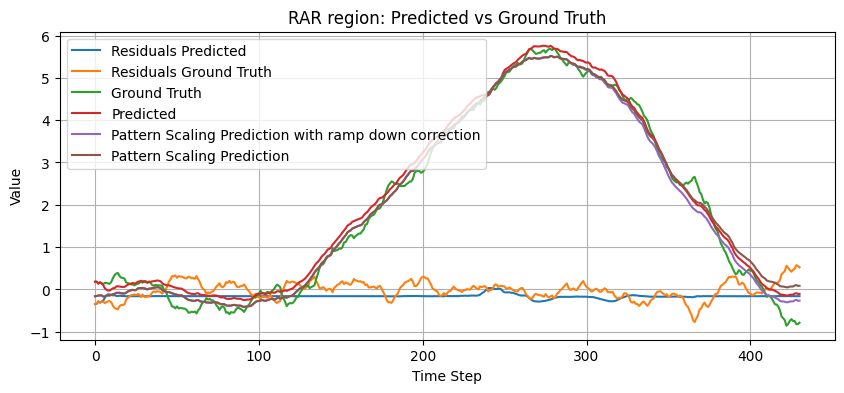

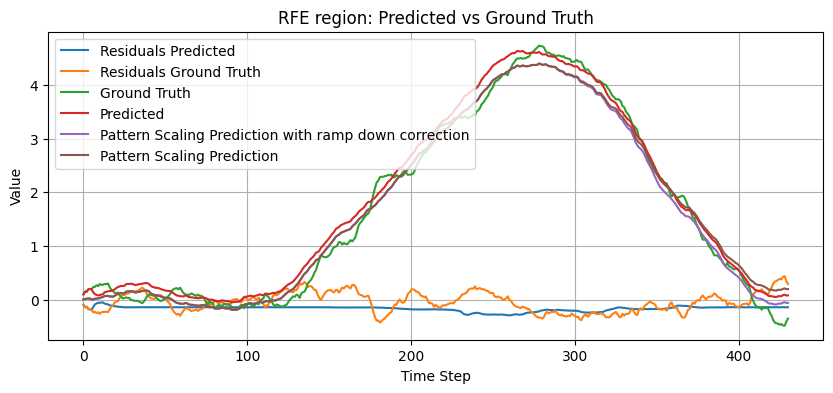

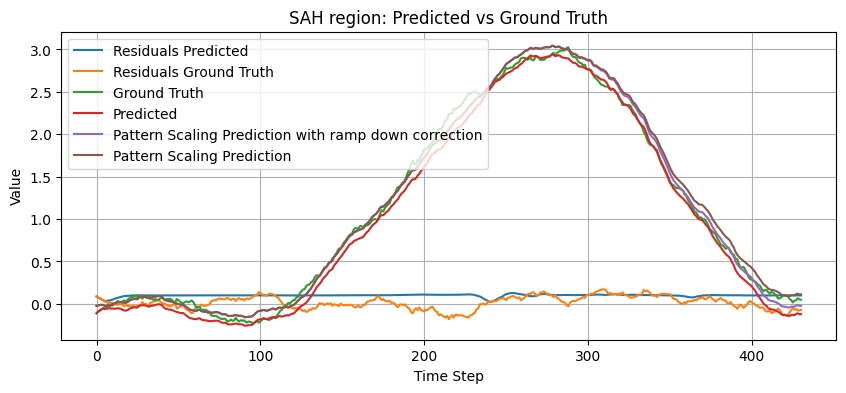

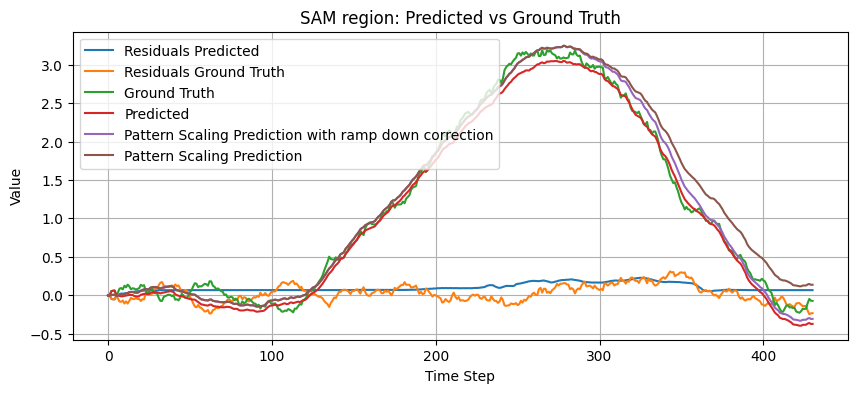

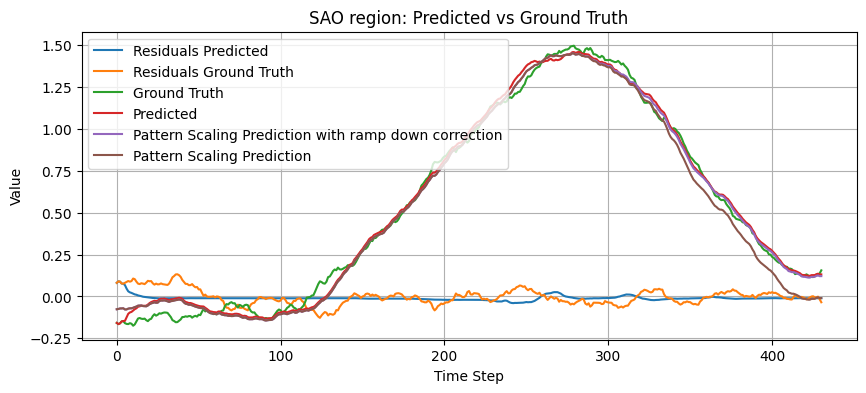

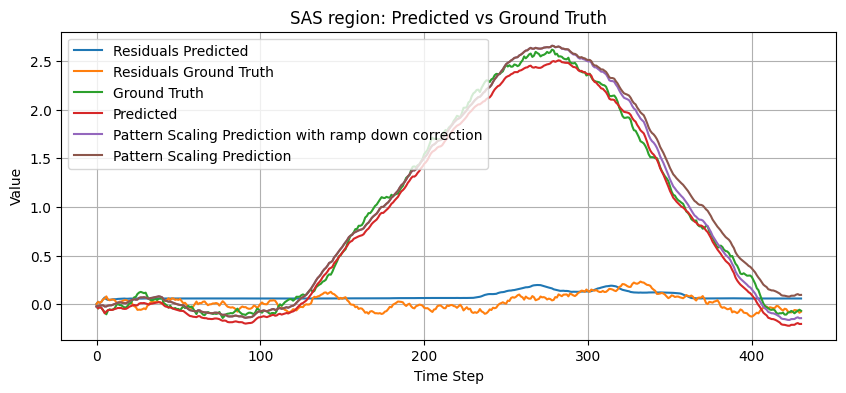

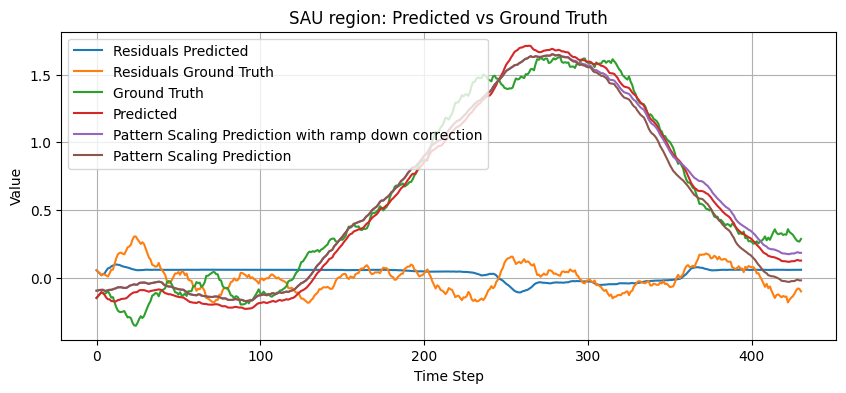

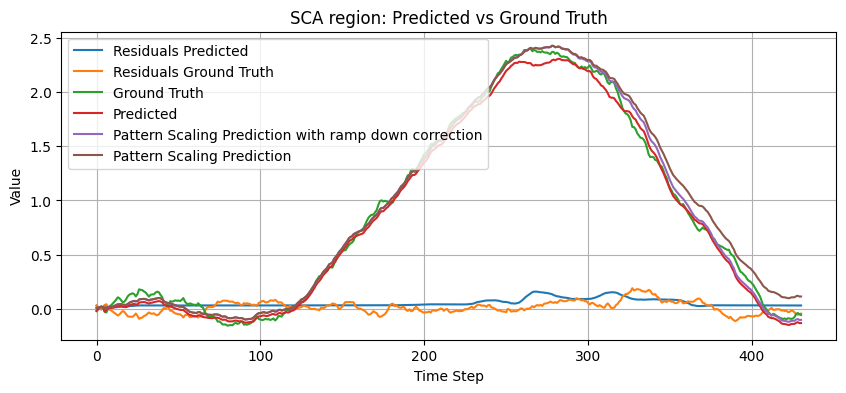

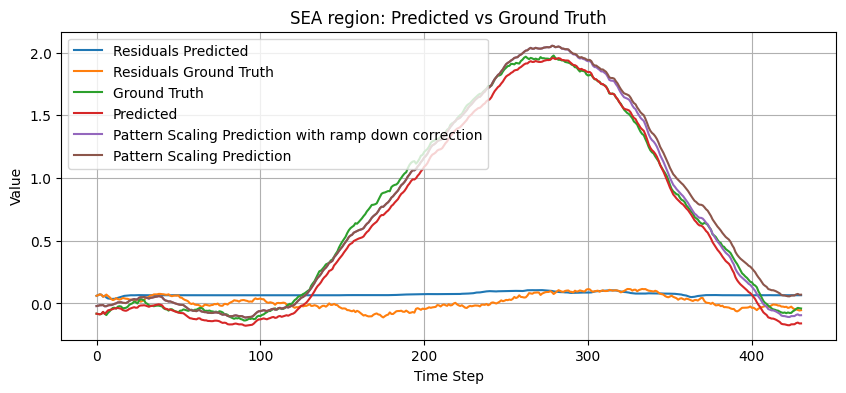

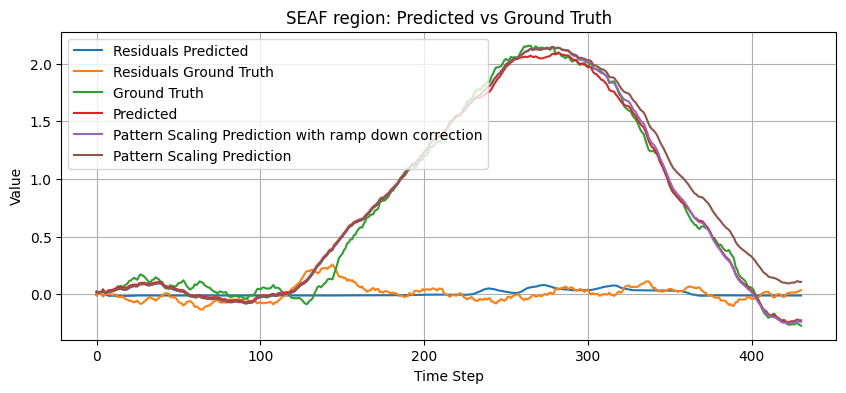

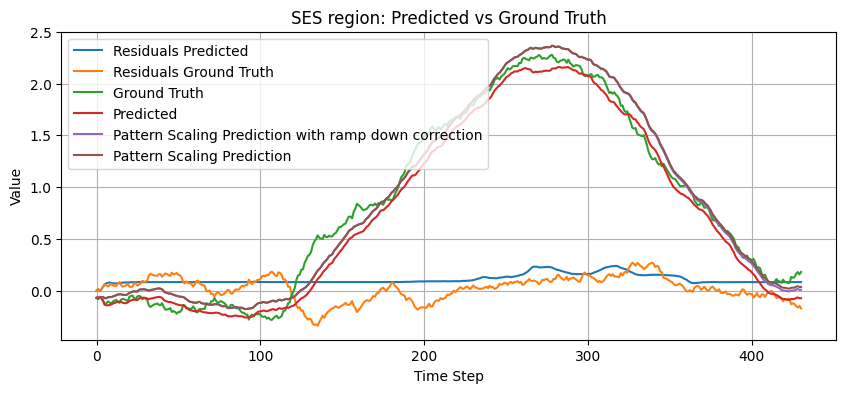

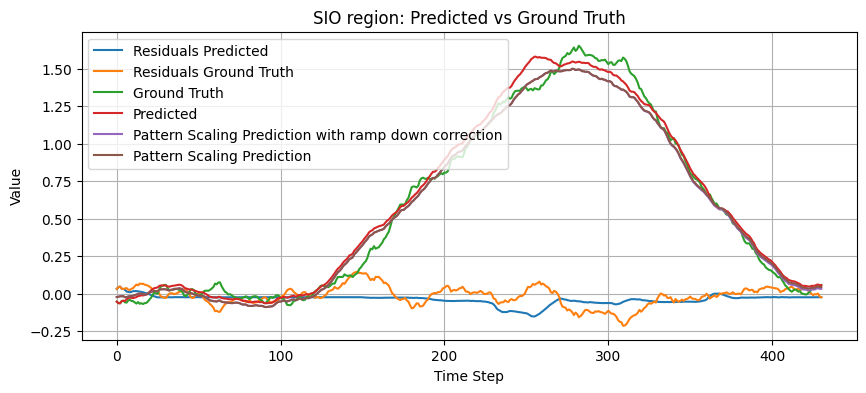

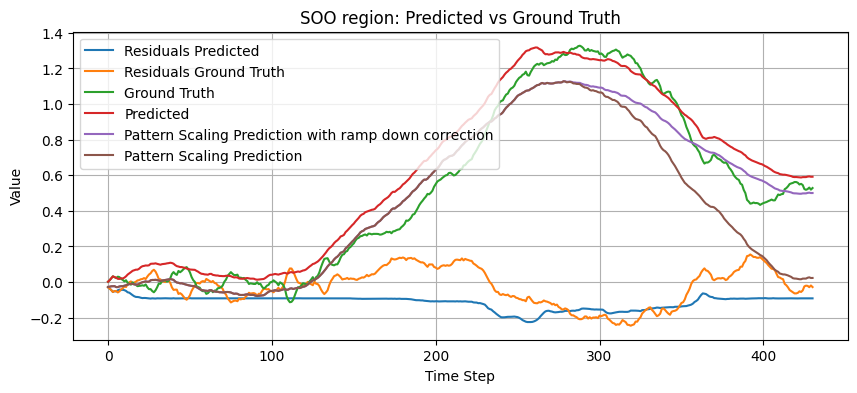

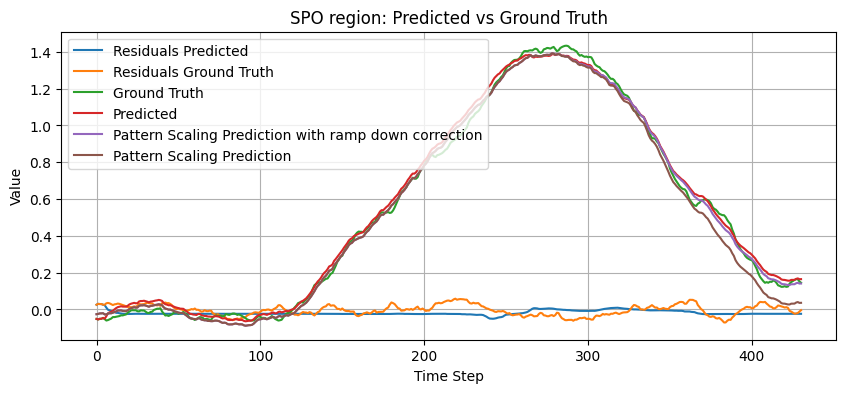

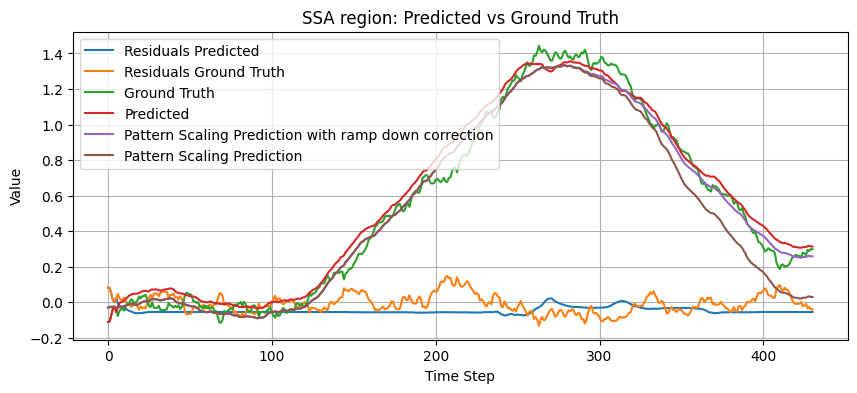

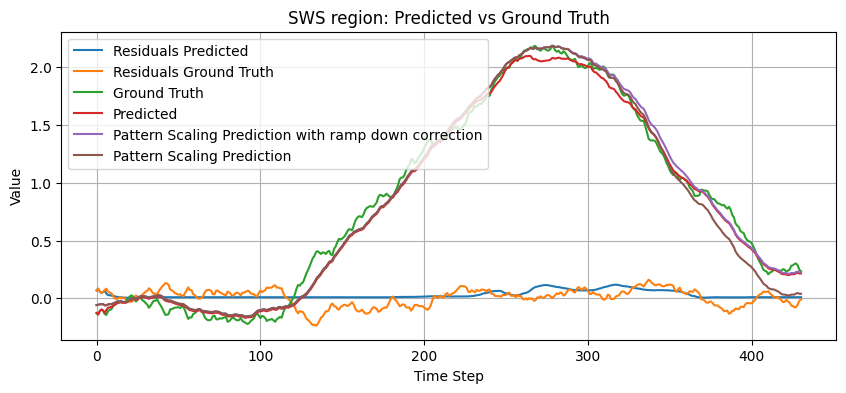

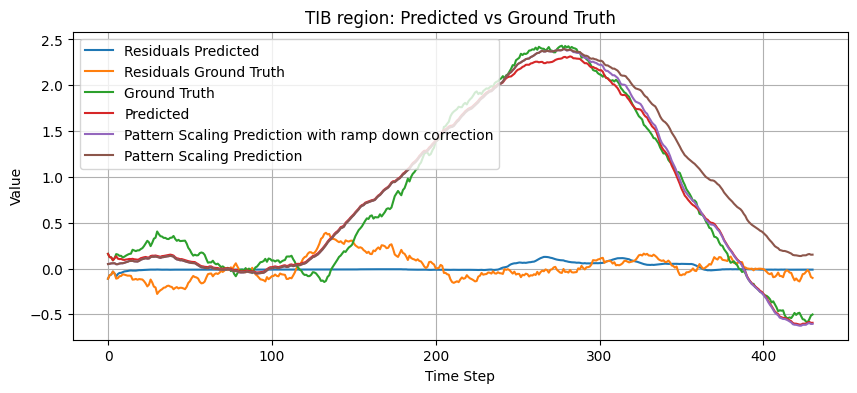

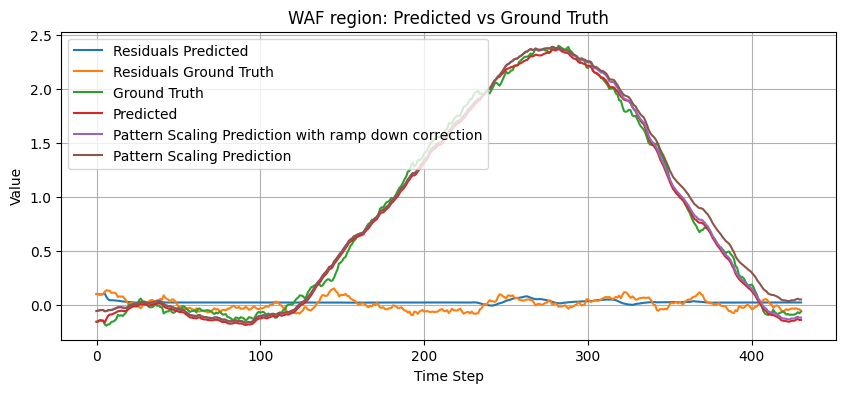

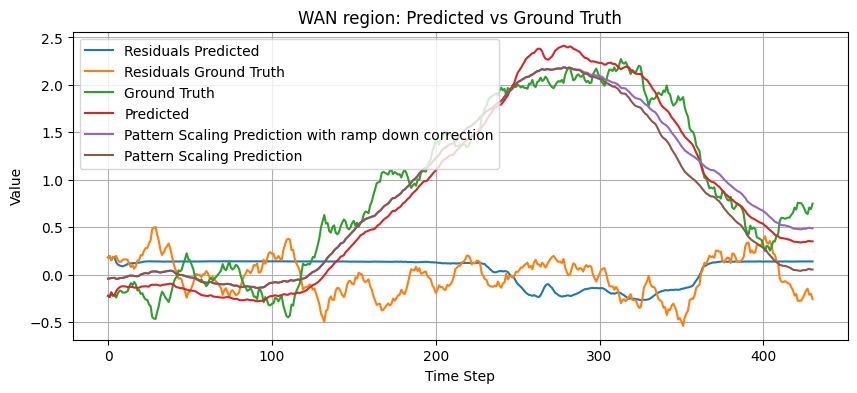

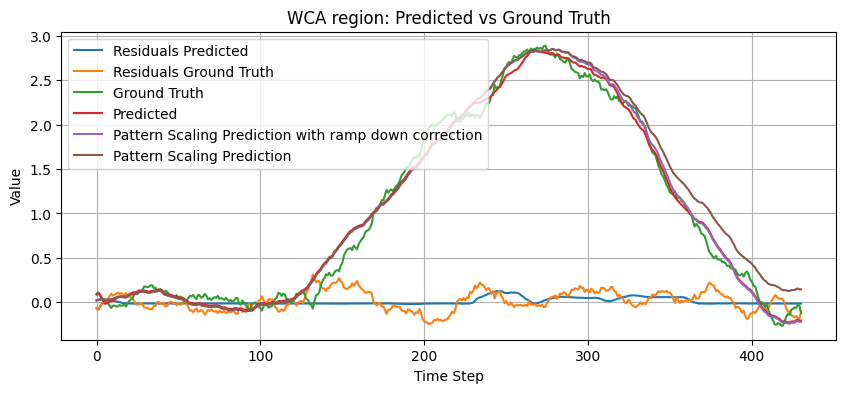

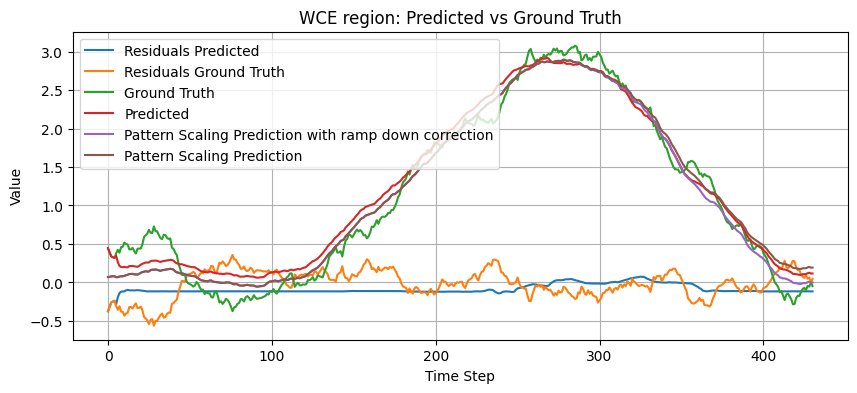

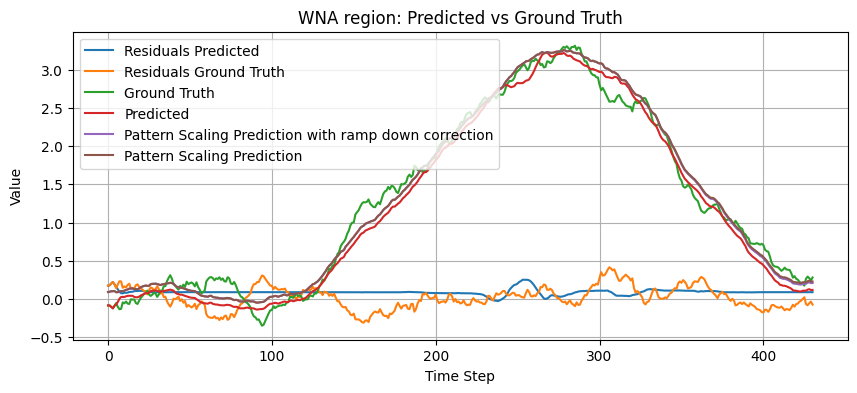

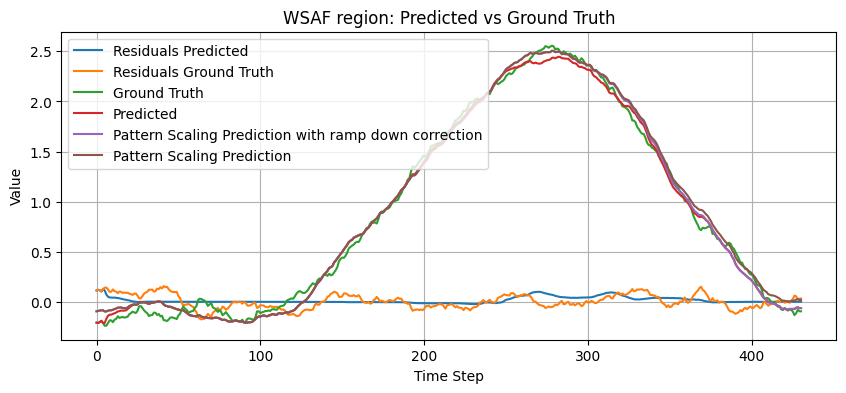

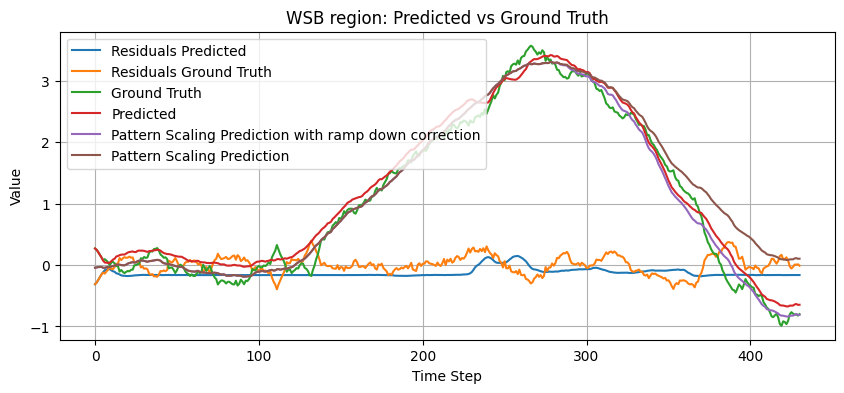

In [13]:
for i in range(num_series):
    plt.figure(figsize=(10, 4))
    
    if PATTERN_SCALING_RESIDUALS:
        plt.plot(range(timesteps),  full_reg_pred_with_spin_off[i], label="Residuals Predicted")
        plt.plot(range(timesteps),autoregressive_test_groudtruth[i], label="Residuals Ground Truth")
        plt.plot(range(timesteps), pattern_scaling_prediction[i,:] - autoregressive_test_groudtruth[i], label="Ground Truth")
        plt.plot(range(timesteps), pattern_scaling_prediction[i,:] - full_reg_pred_with_spin_off[i], label="Predicted")
        plt.plot(range(timesteps), pattern_scaling_prediction[i,:], label="Pattern Scaling Prediction with ramp down correction")
        plt.plot(range(timesteps), pattern_scaling_prediction_no_ramp_down[i,:], label="Pattern Scaling Prediction")
    else:
        plt.plot(range(timesteps), autoregressive_test_groudtruth[i], label="Ground Truth")
        plt.plot(range(timesteps), full_reg_pred_with_spin_off[i], label="Predicted")
        plt.plot(range(timesteps), pattern_scaling_prediction[:,i], label="Pattern Scaling Prediction")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title(f"{region_names[i]} region: Predicted vs Ground Truth")
    plt.legend()
    plt.grid(True)
    plt.show()

(431, 58)
(431, 58)
(431, 58)
(431, 58)


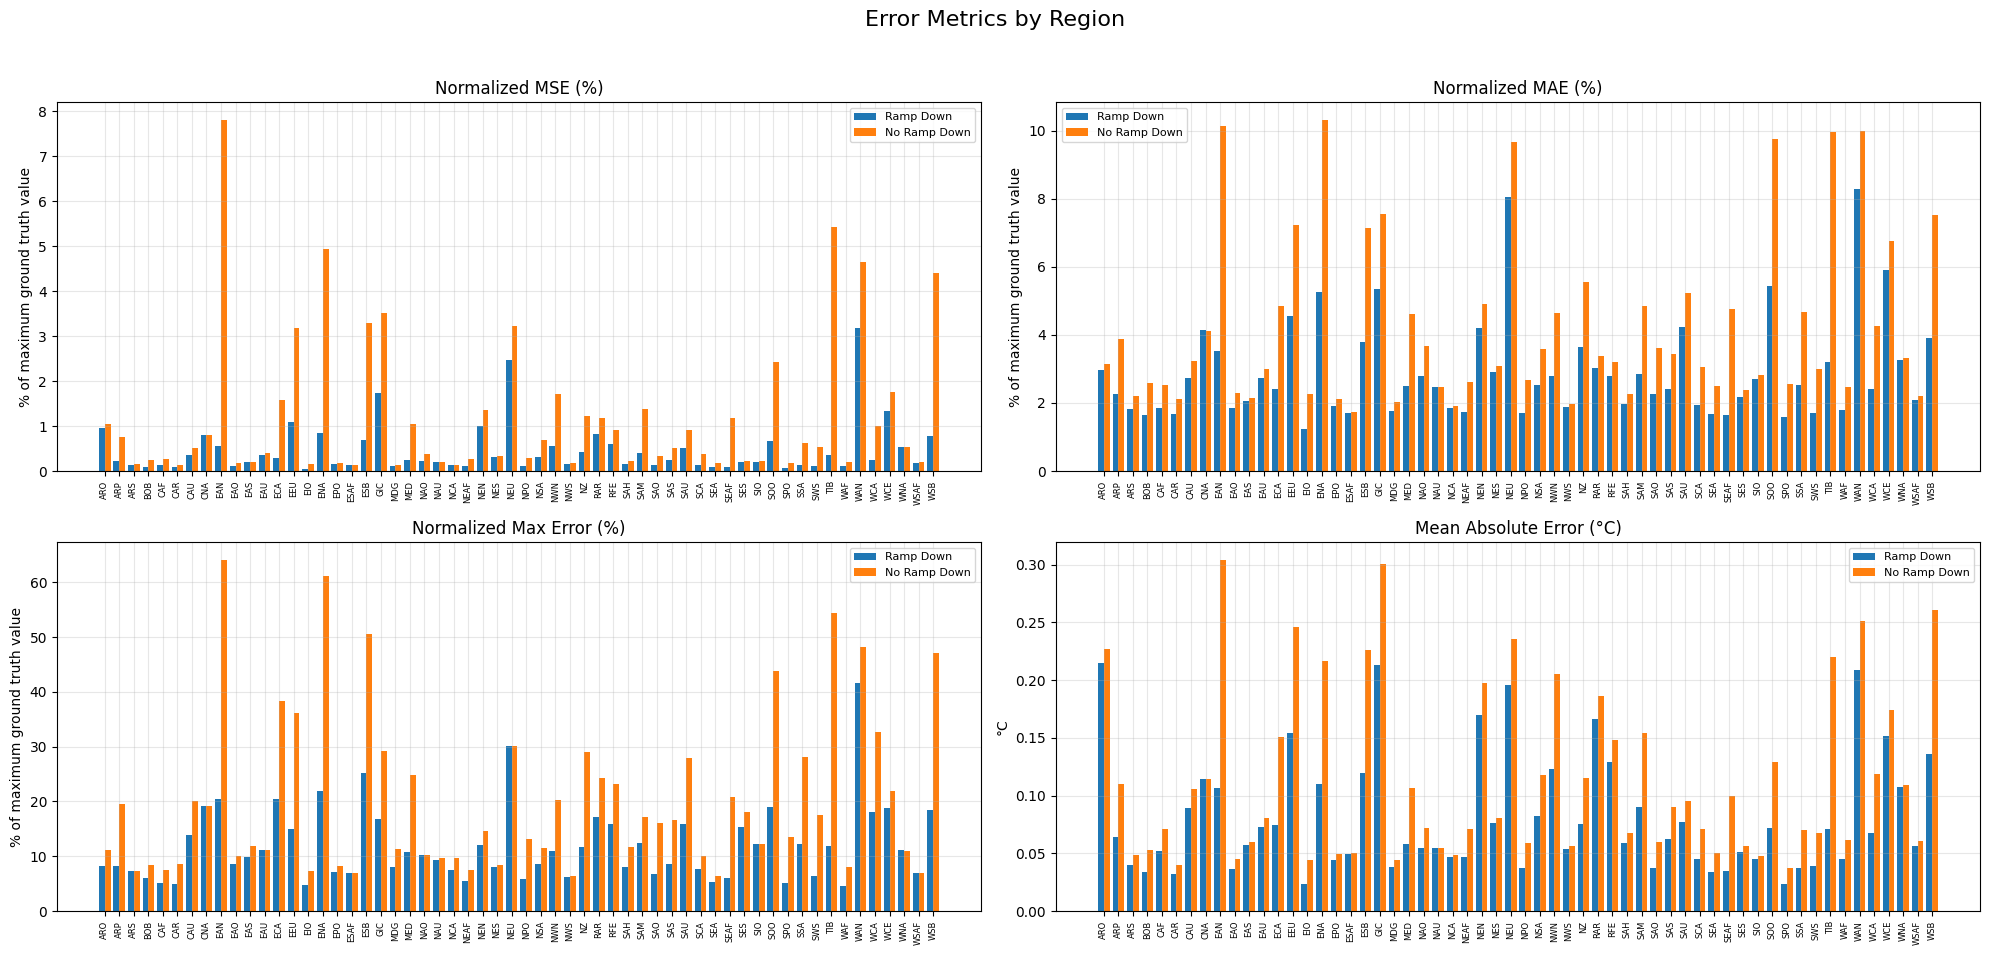

In [38]:
patter_scaling_with_vs_no_rampdown = True

def plot_region_error_metrics(
    pred_list, pred_names, b_real, region_list,
    title="Error Metrics by Region"
):
    """
    Generalized version allowing any number of prediction methods.

    Args:
        pred_list : list of np.ndarray (each N x M) — predicted values
        pred_names : list of str — names of prediction methods (same length as pred_list)
        b_real : np.ndarray (N x M) — real values
        region_list : list of str — region names (length M)
        title : str — plot title
    """

    # --- Input checks ---
    assert len(pred_list) == len(pred_names), "pred_list and pred_names must match in length"
    
    N, M = b_real.shape
    for p in pred_list:
        print(p.shape)
        print(b_real.shape)
        assert p.shape == (N, M), "All predictions must match the shape of b_real"

    assert len(region_list) == M, "region_list length must match number of regions"

    # --- Compute metrics for one prediction ---
    def compute_metrics(b_pred):
        norm_mse, norm_mae, norm_max_err, mae = [], [], [], []
        for i in range(M):
            real = b_real[:, i]
            pred = b_pred[:, i]
            max_real = np.nanmax(real)

            mse = np.nanmean((pred - real)**2)
            mae_val = np.nanmean(np.abs(pred - real))
            max_err_val = np.nanmax(np.abs(pred - real))

            norm_mse.append(100 * mse / max_real)
            norm_mae.append(100 * mae_val / max_real)
            norm_max_err.append(100 * max_err_val / max_real)
            mae.append(mae_val)

        return np.array(norm_mse), np.array(norm_mae), np.array(norm_max_err), np.array(mae)

    # --- Compute for all methods ---
    all_metrics = [compute_metrics(pred) for pred in pred_list]

    metric_names = [
        "Normalized MSE (%)",
        "Normalized MAE (%)",
        "Normalized Max Error (%)",
        "Mean Absolute Error (°C)",
    ]
    y_labels = [
        "% of maximum ground truth value",
        "% of maximum ground truth value",
        "% of maximum ground truth value",
        "°C",
    ]

    # --- Setup figure ---
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle(title, fontsize=16, y=0.95)

    x = np.arange(len(region_list))
    num_methods = len(pred_list)
    width = 0.8 / num_methods   # distribute bars across region

    # --- Loop over metrics (4 panels) ---
    for ax, metric_idx in zip(axes.flatten(), range(4)):
        
        for j, (method_metrics, name) in enumerate(zip(all_metrics, pred_names)):
            data = method_metrics[metric_idx]
            ax.bar(x + (j - num_methods/2) * width + width/2,
                   data, width, label=name)

        ax.set_ylabel(y_labels[metric_idx])
        ax.set_xticks(x)
        ax.set_xticklabels(region_list, rotation=90, fontsize=6)
        ax.set_title(metric_names[metric_idx])
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

if PATTERN_SCALING_RESIDUALS and not patter_scaling_with_vs_no_rampdown:

    plot_region_error_metrics([(pattern_scaling_prediction - full_reg_pred_with_spin_off).transpose(1,0),pattern_scaling_prediction.T], ['XGBoost', 'Pattern Scaling'], (pattern_scaling_prediction - autoregressive_test_groudtruth).transpose(1,0), region_list = [r for r in region_names if r != "GLOBAL"])
elif not patter_scaling_with_vs_no_rampdown:
    plot_region_error_metrics([full_reg_pred_with_spin_off.transpose(1,0),pattern_scaling_prediction], ['XGBoost', 'Pattern Scaling'], autoregressive_test_groudtruth.transpose(1,0), region_list = [r for r in region_names if r != "GLOBAL"])

if patter_scaling_with_vs_no_rampdown: 
    plot_region_error_metrics([pattern_scaling_prediction.T,pattern_scaling_prediction_no_ramp_down.T], ['Ramp Down', 'No Ramp Down'], (pattern_scaling_prediction - autoregressive_test_groudtruth).transpose(1,0), region_list = [r for r in region_names if r != "GLOBAL"])